In [2]:
import warnings; 
warnings.simplefilter('ignore')
import pandas as pd
from pandas import Series
import numpy as np
from numpy import hstack
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
from datetime import datetime, date 
from numpy import array
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from keras.layers import Activation, Dense, Conv1D, ConvLSTM2D, MaxPooling1D, MaxPooling2D, Flatten, Conv2D
from keras.layers import TimeDistributed, RepeatVector
from numpy import hstack
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import missingno
!pip install missingno
#!conda install libpython m2w64-toolchain -c msys2
#!pip install pystan==2.19.1.1
#!pip install prophet --no-cache-dir
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from typing import Iterable, List
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import schedules
!pip install optuna
import optuna
import joblib

You should consider upgrading via the 'C:\Users\dimit\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\dimit\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
#DATA PREPARATION

In [5]:
#COUNTRIES DATASET
countries = pd.read_csv("energy_data.csv")
countries

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50396,2020-09-30T19:00:00Z,2020-09-30T21:00:00+0200,6661.0,6656.0,NaN,NaN,1847.0,9402.0,9720.0,NaN,...,1506.95,1530.0,5.32,0.44,3324.0,3170.0,1.7,1.1,NaN,NaN
50397,2020-09-30T20:00:00Z,2020-09-30T22:00:00+0200,6336.0,6310.0,NaN,NaN,1723.0,9219.0,9418.0,NaN,...,1391.15,1388.0,5.57,0.62,3099.0,3010.0,1.7,1.0,NaN,NaN
50398,2020-09-30T21:00:00Z,2020-09-30T23:00:00+0200,5932.0,5813.0,NaN,NaN,1771.0,8763.0,8873.0,NaN,...,1250.17,1274.0,5.58,0.66,2940.0,2890.0,1.6,1.0,NaN,NaN
50399,2020-09-30T22:00:00Z,2020-10-01T00:00:00+0200,5628.0,5424.0,NaN,NaN,1779.0,8131.0,8285.0,NaN,...,1206.82,1178.0,5.61,0.21,2823.0,2740.0,1.7,1.2,NaN,NaN


In [6]:
countries['utc_timestamp']= pd.to_datetime(countries['utc_timestamp']).dt.tz_localize(None)

countries['year'] = countries['utc_timestamp'].dt.year
countries['month'] = countries['utc_timestamp'].dt.month
countries['week'] = countries['utc_timestamp'].dt.week
countries['day'] = countries['utc_timestamp'].dt.day

In [7]:
values = countries['month'].index
sine = np.sin(values*2*np.pi/len(values))
cosine = np.cos(values*2*np.pi/len(values))
countries['month_sin'] = sine
countries['month_cos'] = cosine

countries

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency,year,month,week,day,month_sin,month_cos
0,2014-12-31 23:00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2014,12,1,31,0.000000,1.0
1,2015-01-01 00:00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,2015,1,1,1,0.000125,1.0
2,2015-01-01 01:00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000249,1.0
3,2015-01-01 02:00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000374,1.0
4,2015-01-01 03:00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000499,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50396,2020-09-30 19:00:00,2020-09-30T21:00:00+0200,6661.0,6656.0,NaN,NaN,1847.0,9402.0,9720.0,NaN,...,1.7,1.1,NaN,NaN,2020,9,40,30,-0.000623,1.0
50397,2020-09-30 20:00:00,2020-09-30T22:00:00+0200,6336.0,6310.0,NaN,NaN,1723.0,9219.0,9418.0,NaN,...,1.7,1.0,NaN,NaN,2020,9,40,30,-0.000499,1.0
50398,2020-09-30 21:00:00,2020-09-30T23:00:00+0200,5932.0,5813.0,NaN,NaN,1771.0,8763.0,8873.0,NaN,...,1.6,1.0,NaN,NaN,2020,9,40,30,-0.000374,1.0
50399,2020-09-30 22:00:00,2020-10-01T00:00:00+0200,5628.0,5424.0,NaN,NaN,1779.0,8131.0,8285.0,NaN,...,1.7,1.2,NaN,NaN,2020,9,40,30,-0.000249,1.0


In [8]:
countries.index = pd.to_datetime(countries['utc_timestamp']).dt.tz_localize(None)
mask1 = (countries['utc_timestamp'] > "2015-01-01 00:00:00") & (countries['utc_timestamp'] <= "2019-12-31 19:00:00")
countries = countries.loc[mask1]
countries

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency,year,month,week,day,month_sin,month_cos
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 01:00:00,2015-01-01 01:00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000249,1.000000
2015-01-01 02:00:00,2015-01-01 02:00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000374,1.000000
2015-01-01 03:00:00,2015-01-01 03:00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000499,1.000000
2015-01-01 04:00:00,2015-01-01 04:00:00,2015-01-01T05:00:00+0100,5309.0,6609.0,35.0,NaN,64.0,8487.0,8806.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000623,1.000000
2015-01-01 05:00:00,2015-01-01 05:00:00,2015-01-01T06:00:00+0100,5574.0,6543.0,35.0,NaN,84.0,8428.0,8805.0,NaN,...,3.8,NaN,NaN,NaN,2015,1,1,1,0.000748,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00,2019-12-31 15:00:00,2019-12-31T16:00:00+0100,7528.0,8009.0,NaN,19.0,2243.0,10081.0,10308.0,13.14,...,8.8,0.9,20672.0,21020.0,2019,12,1,31,-0.731768,0.681554
2019-12-31 16:00:00,2019-12-31 16:00:00,2019-12-31T17:00:00+0100,7807.0,8248.0,NaN,7.0,2048.0,10381.0,10870.0,0.00,...,0.6,0.9,20357.0,21160.0,2019,12,1,31,-0.731683,0.681645
2019-12-31 17:00:00,2019-12-31 17:00:00,2019-12-31T18:00:00+0100,7721.0,8090.0,NaN,4.0,2088.0,10053.0,10842.0,0.00,...,0.5,1.2,19816.0,20960.0,2019,12,1,31,-0.731598,0.681737


<AxesSubplot:>

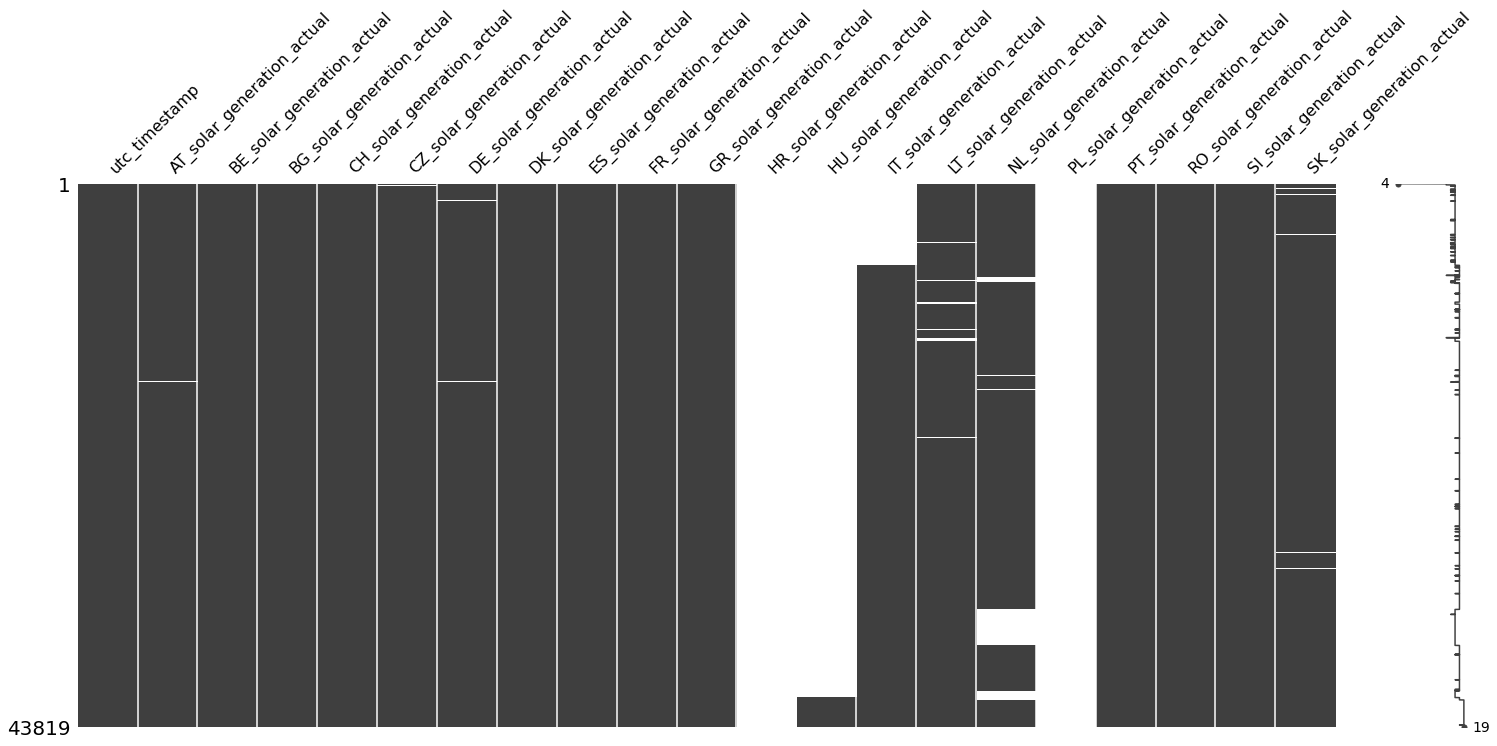

In [9]:
countries = countries [['utc_timestamp','AT_solar_generation_actual','BE_solar_generation_actual','BG_solar_generation_actual', 'CH_solar_generation_actual','CZ_solar_generation_actual','DE_solar_generation_actual','DK_solar_generation_actual','ES_solar_generation_actual','FR_solar_generation_actual','GR_solar_generation_actual','HR_solar_generation_actual','HU_solar_generation_actual','IT_solar_generation_actual','LT_solar_generation_actual', 'NL_solar_generation_actual','PL_solar_generation_actual','PT_solar_generation_actual','RO_solar_generation_actual','SI_solar_generation_actual','SK_solar_generation_actual']]

missingno.matrix(countries)

Text(0.5, 1.0, 'Solar generation in Germany')

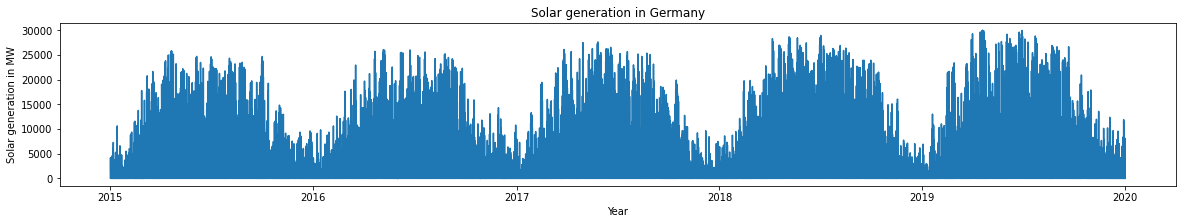

In [10]:
plt.plot(countries['DE_solar_generation_actual'])
plt.xlabel('Year')
plt.ylabel('Solar generation in MW')
plt.title('Solar generation in Germany')

Text(0.5, 1.0, 'Solar generation in Greece')

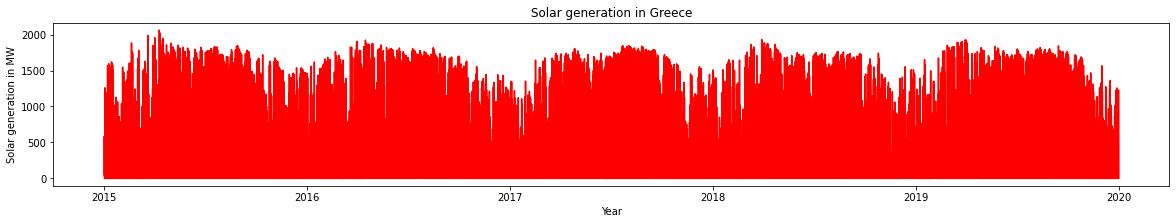

In [11]:
plt.plot(countries['GR_solar_generation_actual'], color='red')
plt.xlabel('Year')
plt.ylabel('Solar generation in MW')
plt.title('Solar generation in Greece')

In [12]:
#WEATHER DATASET
weather = pd.read_csv("weather_data.csv")
weather.index = pd.to_datetime(weather['utc_timestamp']).dt.tz_localize(None)
weather

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00,1980-01-01T00:00:00Z,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00,1980-01-01T01:00:00Z,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00,1980-01-01T02:00:00Z,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00,1980-01-01T03:00:00Z,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00,1980-01-01T04:00:00Z,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019-12-31T19:00:00Z,-1.386,0.0,0.0,1.684,0.0,0.0,-1.351,0.0,0.0,...,0.0,-0.382,0.0,0.0,0.053,0.0,0.0,-0.766,0.0,0.0
2019-12-31 20:00:00,2019-12-31T20:00:00Z,-1.661,0.0,0.0,1.718,0.0,0.0,-1.009,0.0,0.0,...,0.0,-0.418,0.0,0.0,-0.207,0.0,0.0,-0.742,0.0,0.0
2019-12-31 21:00:00,2019-12-31T21:00:00Z,-1.986,0.0,0.0,1.726,0.0,0.0,-0.986,0.0,0.0,...,0.0,-0.490,0.0,0.0,-0.203,0.0,0.0,-0.764,0.0,0.0


In [13]:
mask2 = (weather['utc_timestamp'] > "2015-01-01 00:00:00") & (weather['utc_timestamp'] <= "2019-12-31 19:00:00")
weather = weather.loc[mask2]
weather

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01T00:00:00Z,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00,2015-01-01T01:00:00Z,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00,2015-01-01T02:00:00Z,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00,2015-01-01T03:00:00Z,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00,2015-01-01T04:00:00Z,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,2019-12-30T19:00:00Z,-1.966,0.0,0.0,0.381,0.0,0.0,-4.800,0.0,0.0,...,0.0,4.427,0.0,0.0,-2.730,0.0,0.0,-3.966,0.0,0.0
2019-12-30 20:00:00,2019-12-30T20:00:00Z,-1.934,0.0,0.0,0.142,0.0,0.0,-5.148,0.0,0.0,...,0.0,4.245,0.0,0.0,-2.937,0.0,0.0,-4.090,0.0,0.0
2019-12-30 21:00:00,2019-12-30T21:00:00Z,-1.766,0.0,0.0,-0.082,0.0,0.0,-5.467,0.0,0.0,...,0.0,4.055,0.0,0.0,-2.968,0.0,0.0,-4.208,0.0,0.0


In [14]:
weather = weather [['utc_timestamp','AT_temperature', 'AT_radiation_direct_horizontal', 'BE_temperature', 'BE_radiation_direct_horizontal','BG_temperature','BG_radiation_direct_horizontal', 'CH_temperature', 'CH_radiation_direct_horizontal','CZ_temperature', 'CZ_radiation_direct_horizontal','DE_temperature', 'DE_radiation_direct_horizontal', 'DK_temperature', 'DK_radiation_direct_horizontal','ES_temperature', 'ES_radiation_direct_horizontal', 'FR_temperature', 'FR_radiation_direct_horizontal', 'GR_temperature', 'GR_radiation_direct_horizontal','HR_temperature', 'HR_radiation_direct_horizontal', 'HU_temperature', 'HU_radiation_direct_horizontal','IT_temperature', 'IT_radiation_direct_horizontal','LT_temperature','LT_radiation_direct_horizontal', 'NL_temperature', 'NL_radiation_direct_horizontal','PL_temperature', 'PL_radiation_direct_horizontal','PT_temperature', 'PT_radiation_direct_horizontal','RO_temperature', 'RO_radiation_direct_horizontal', 'SI_temperature', 'SI_radiation_direct_horizontal', 'SK_temperature', 'SK_radiation_direct_horizontal']]
weather

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,BE_temperature,BE_radiation_direct_horizontal,BG_temperature,BG_radiation_direct_horizontal,CH_temperature,CH_radiation_direct_horizontal,CZ_temperature,...,PL_temperature,PL_radiation_direct_horizontal,PT_temperature,PT_radiation_direct_horizontal,RO_temperature,RO_radiation_direct_horizontal,SI_temperature,SI_radiation_direct_horizontal,SK_temperature,SK_radiation_direct_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01T00:00:00Z,-6.503,0.0,-0.046,0.0,-13.350,0.0,-9.152,0.0,-2.372,...,-1.198,0.0,5.584,0.0,-14.323,0.0,-11.261,0.0,-8.272,0.0
2015-01-01 01:00:00,2015-01-01T01:00:00Z,-6.458,0.0,-0.302,0.0,-13.594,0.0,-8.946,0.0,-2.126,...,-1.052,0.0,5.219,0.0,-14.166,0.0,-10.975,0.0,-8.114,0.0
2015-01-01 02:00:00,2015-01-01T02:00:00Z,-6.253,0.0,-0.541,0.0,-13.781,0.0,-8.676,0.0,-1.839,...,-0.925,0.0,5.034,0.0,-14.008,0.0,-10.772,0.0,-7.898,0.0
2015-01-01 03:00:00,2015-01-01T03:00:00Z,-5.908,0.0,-0.794,0.0,-14.042,0.0,-8.373,0.0,-1.521,...,-0.793,0.0,4.708,0.0,-13.963,0.0,-10.667,0.0,-7.670,0.0
2015-01-01 04:00:00,2015-01-01T04:00:00Z,-5.516,0.0,-1.053,0.0,-14.340,0.0,-8.140,0.0,-1.223,...,-0.627,0.0,4.353,0.0,-14.021,0.0,-10.467,0.0,-7.399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,2019-12-30T19:00:00Z,-1.966,0.0,0.381,0.0,-4.800,0.0,-0.464,0.0,-1.713,...,0.078,0.0,10.928,0.0,-4.938,0.0,-2.730,0.0,-3.966,0.0
2019-12-30 20:00:00,2019-12-30T20:00:00Z,-1.934,0.0,0.142,0.0,-5.148,0.0,-0.503,0.0,-1.830,...,-0.141,0.0,10.325,0.0,-5.058,0.0,-2.937,0.0,-4.090,0.0
2019-12-30 21:00:00,2019-12-30T21:00:00Z,-1.766,0.0,-0.082,0.0,-5.467,0.0,-0.361,0.0,-1.785,...,-0.165,0.0,9.728,0.0,-4.995,0.0,-2.968,0.0,-4.208,0.0


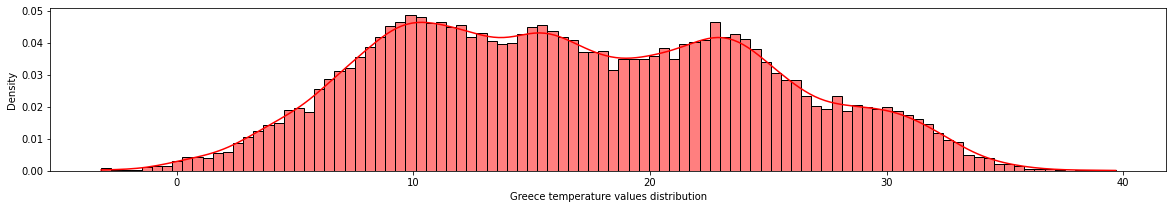

In [15]:
sns.histplot(data=weather['GR_temperature'], kde=True, label='Germany', bins=100, stat='density', common_norm=False, color='red')
plt.xlabel('Greece temperature values distribution')
plt.show()

Text(0.5, 1.0, 'Solar radiation in Greece')

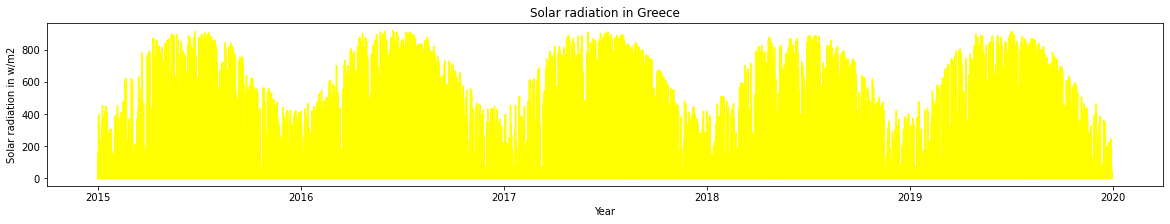

In [16]:
plt.plot(weather['GR_radiation_direct_horizontal'], color='yellow')
plt.xlabel('Year')
plt.ylabel('Solar radiation in w/m2')
plt.title('Solar radiation in Greece')

In [17]:
df = pd.concat([countries, weather], axis=1)
df

,utc_timestamp,AT_solar_generation_actual,BE_solar_generation_actual,BG_solar_generation_actual,CH_solar_generation_actual,CZ_solar_generation_actual,DE_solar_generation_actual,DK_solar_generation_actual,ES_solar_generation_actual,FR_solar_generation_actual,...,PL_temperature,PL_radiation_direct_horizontal,PT_temperature,PT_radiation_direct_horizontal,RO_temperature,RO_radiation_direct_horizontal,SI_temperature,SI_radiation_direct_horizontal,SK_temperature,SK_radiation_direct_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.198,0.0,5.584,0.0,-14.323,0.0,-11.261,0.0,-8.272,0.0
2015-01-01 01:00:00,2015-01-01 01:00:00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,50.0,NaN,...,-1.052,0.0,5.219,0.0,-14.166,0.0,-10.975,0.0,-8.114,0.0
2015-01-01 02:00:00,2015-01-01 02:00:00,NaN,NaN,NaN,0.07,NaN,NaN,NaN,50.0,NaN,...,-0.925,0.0,5.034,0.0,-14.008,0.0,-10.772,0.0,-7.898,0.0
2015-01-01 03:00:00,2015-01-01 03:00:00,NaN,NaN,NaN,0.07,NaN,NaN,NaN,42.0,NaN,...,-0.793,0.0,4.708,0.0,-13.963,0.0,-10.667,0.0,-7.670,0.0
2015-01-01 04:00:00,2015-01-01 04:00:00,NaN,NaN,NaN,0.07,NaN,NaN,0.01,34.0,NaN,...,-0.627,0.0,4.353,0.0,-14.021,0.0,-10.467,0.0,-7.399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00,2019-12-31 15:00:00,19.0,13.14,0.0,2.40,9.61,46.0,0.73,2999.0,454.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 16:00:00,2019-12-31 16:00:00,7.0,0.00,0.0,0.00,0.00,0.0,0.00,1250.0,109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 17:00:00,2019-12-31 17:00:00,4.0,0.00,0.0,0.00,0.00,0.0,0.00,182.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
columns = [column for column in df.columns if ('solar_generation_actual' in column or 'temperature' in column or "month" in column or "radiation" in column)]
dataset = df[columns]
dataset

,AT_solar_generation_actual,BE_solar_generation_actual,BG_solar_generation_actual,CH_solar_generation_actual,CZ_solar_generation_actual,DE_solar_generation_actual,DK_solar_generation_actual,ES_solar_generation_actual,FR_solar_generation_actual,GR_solar_generation_actual,...,PL_temperature,PL_radiation_direct_horizontal,PT_temperature,PT_radiation_direct_horizontal,RO_temperature,RO_radiation_direct_horizontal,SI_temperature,SI_radiation_direct_horizontal,SK_temperature,SK_radiation_direct_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.198,0.0,5.584,0.0,-14.323,0.0,-11.261,0.0,-8.272,0.0
2015-01-01 01:00:00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,50.0,NaN,NaN,...,-1.052,0.0,5.219,0.0,-14.166,0.0,-10.975,0.0,-8.114,0.0
2015-01-01 02:00:00,NaN,NaN,NaN,0.07,NaN,NaN,NaN,50.0,NaN,NaN,...,-0.925,0.0,5.034,0.0,-14.008,0.0,-10.772,0.0,-7.898,0.0
2015-01-01 03:00:00,NaN,NaN,NaN,0.07,NaN,NaN,NaN,42.0,NaN,NaN,...,-0.793,0.0,4.708,0.0,-13.963,0.0,-10.667,0.0,-7.670,0.0
2015-01-01 04:00:00,NaN,NaN,NaN,0.07,NaN,NaN,0.01,34.0,NaN,NaN,...,-0.627,0.0,4.353,0.0,-14.021,0.0,-10.467,0.0,-7.399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00,19.0,13.14,0.0,2.40,9.61,46.0,0.73,2999.0,454.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 16:00:00,7.0,0.00,0.0,0.00,0.00,0.0,0.00,1250.0,109.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 17:00:00,4.0,0.00,0.0,0.00,0.00,0.0,0.00,182.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#We will make a selection of countries which will be based on the countries values' distribution. For this reason, a
#normalization method should be applied to all the data
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

data = normalize(dataset)
data

,AT_solar_generation_actual,BE_solar_generation_actual,BG_solar_generation_actual,CH_solar_generation_actual,CZ_solar_generation_actual,DE_solar_generation_actual,DK_solar_generation_actual,ES_solar_generation_actual,FR_solar_generation_actual,GR_solar_generation_actual,...,NL_temperature,NL_radiation_direct_horizontal,PT_temperature,PT_radiation_direct_horizontal,RO_temperature,RO_radiation_direct_horizontal,SI_temperature,SI_radiation_direct_horizontal,SK_temperature,SK_radiation_direct_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.231482,0.0,0.143403,0.0,0.041748,0.0,0.166900,0.0,0.196597,0.0
2015-01-01 01:00:00,NaN,NaN,NaN,0.000048,NaN,NaN,NaN,0.007410,NaN,NaN,...,0.225760,0.0,0.133296,0.0,0.044662,0.0,0.171974,0.0,0.199510,0.0
2015-01-01 02:00:00,NaN,NaN,NaN,0.000067,NaN,NaN,NaN,0.007410,NaN,NaN,...,0.221610,0.0,0.128174,0.0,0.047595,0.0,0.175575,0.0,0.203491,0.0
2015-01-01 03:00:00,NaN,NaN,NaN,0.000067,NaN,NaN,NaN,0.006224,NaN,NaN,...,0.216967,0.0,0.119147,0.0,0.048431,0.0,0.177438,0.0,0.207694,0.0
2015-01-01 04:00:00,NaN,NaN,NaN,0.000067,NaN,NaN,0.000012,0.005039,NaN,NaN,...,0.213497,0.0,0.109317,0.0,0.047354,0.0,0.180986,0.0,0.212690,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00,0.019467,0.004852,0.0,0.002294,0.005577,0.001532,0.000910,0.444428,0.067690,0.001455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 16:00:00,0.007172,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.185240,0.016252,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 17:00:00,0.004098,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.026971,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

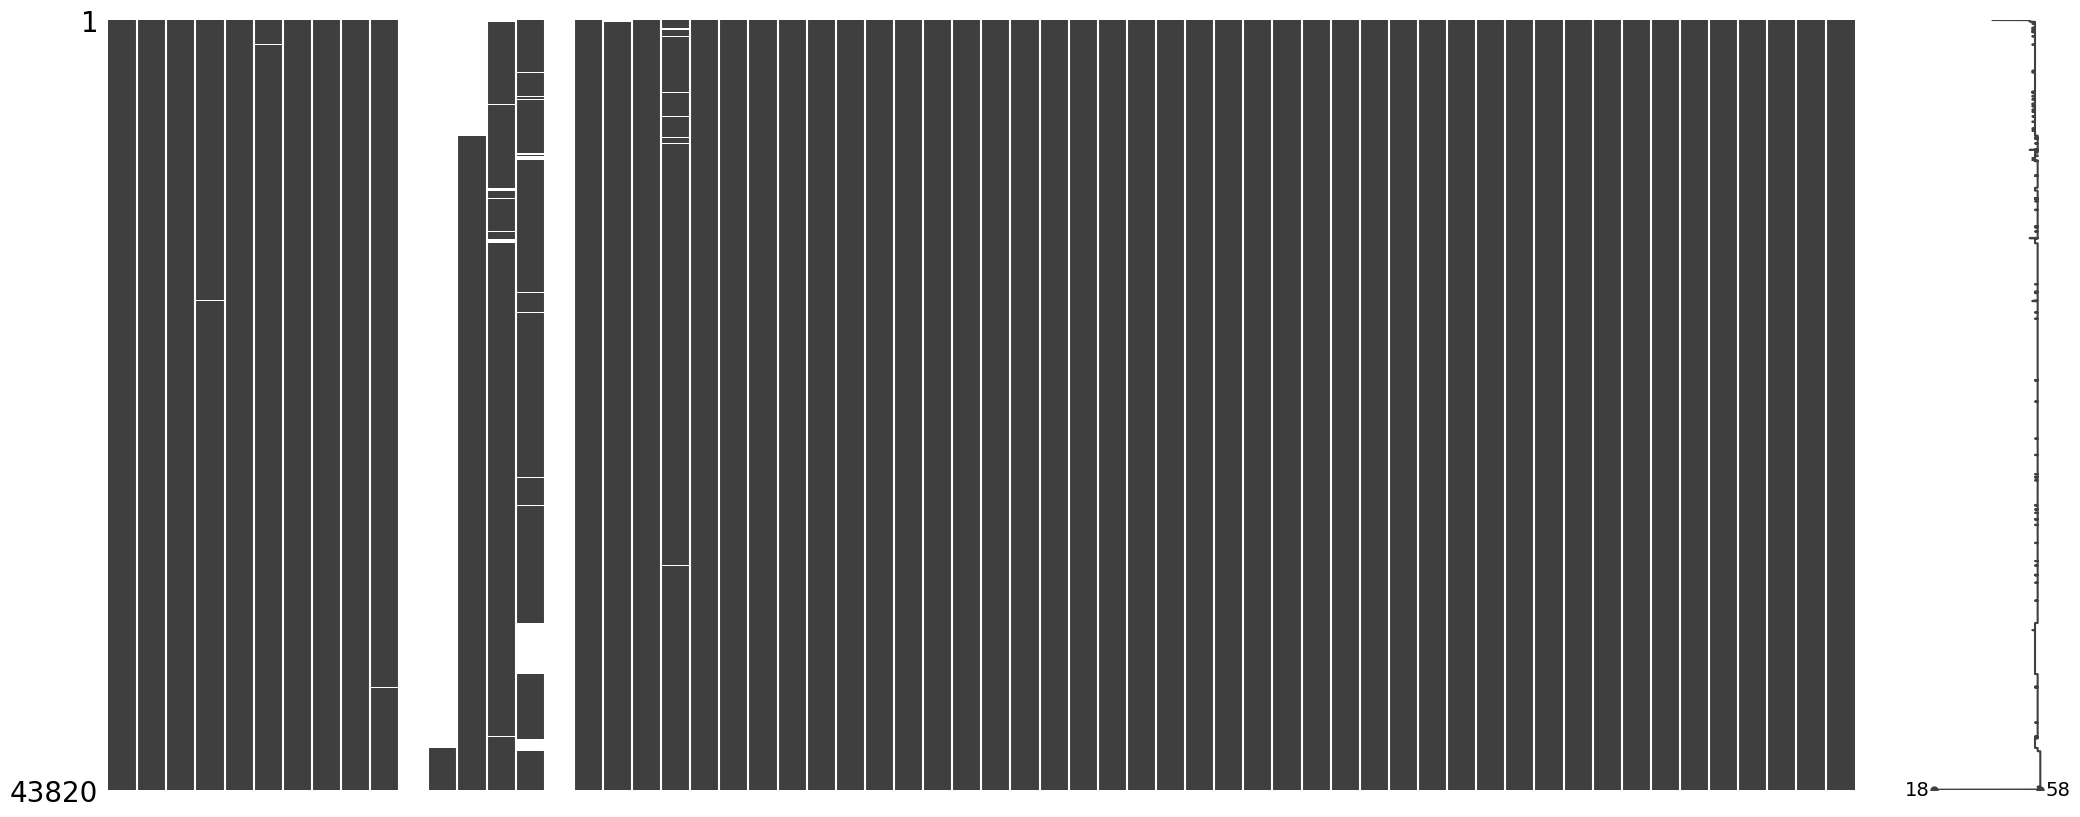

In [21]:
missingno.matrix(dataset)

In [22]:
def showMissingValues(dataframe):
    df_desc = pd.DataFrame(columns=['Column', 'Missing'])

    for col in dataframe.columns:
        df_desc = df_desc.append({'Column': col,'Missing': (dataframe[col].isnull().sum() * 100 / len(dataframe[col]))}, ignore_index = True)
    
    return df_desc

showMissingValues(dataset)

,Column,Missing
0,AT_solar_generation_actual,0.125513
1,BE_solar_generation_actual,0.018257
2,BG_solar_generation_actual,0.015974
3,CH_solar_generation_actual,0.109539
4,CZ_solar_generation_actual,0.063898
5,DE_solar_generation_actual,0.235052
6,DK_solar_generation_actual,0.009128
7,ES_solar_generation_actual,0.027385
8,FR_solar_generation_actual,0.029667
9,GR_solar_generation_actual,0.089000


In [27]:
#drop countries whose data consists mainly of missing values 
dcolumns = [column for column in dataset.columns if ('HR' in column or 'HU' in column or 'PL' in column)]
dataset = dataset.drop(columns=dcolumns)
dataset

,AT_solar_generation_actual,BE_solar_generation_actual,BG_solar_generation_actual,CH_solar_generation_actual,CZ_solar_generation_actual,DE_solar_generation_actual,DK_solar_generation_actual,ES_solar_generation_actual,FR_solar_generation_actual,GR_solar_generation_actual,...,NL_temperature,NL_radiation_direct_horizontal,PT_temperature,PT_radiation_direct_horizontal,RO_temperature,RO_radiation_direct_horizontal,SI_temperature,SI_radiation_direct_horizontal,SK_temperature,SK_radiation_direct_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.869,0.0,5.584,0.0,-14.323,0.0,-11.261,0.0,-8.272,0.0
2015-01-01 01:00:00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,50.0,NaN,NaN,...,1.625,0.0,5.219,0.0,-14.166,0.0,-10.975,0.0,-8.114,0.0
2015-01-01 02:00:00,NaN,NaN,NaN,0.07,NaN,NaN,NaN,50.0,NaN,NaN,...,1.448,0.0,5.034,0.0,-14.008,0.0,-10.772,0.0,-7.898,0.0
2015-01-01 03:00:00,NaN,NaN,NaN,0.07,NaN,NaN,NaN,42.0,NaN,NaN,...,1.250,0.0,4.708,0.0,-13.963,0.0,-10.667,0.0,-7.670,0.0
2015-01-01 04:00:00,NaN,NaN,NaN,0.07,NaN,NaN,0.01,34.0,NaN,NaN,...,1.102,0.0,4.353,0.0,-14.021,0.0,-10.467,0.0,-7.399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00,19.0,13.14,0.0,2.40,9.61,46.0,0.73,2999.0,454.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 16:00:00,7.0,0.00,0.0,0.00,0.00,0.0,0.00,1250.0,109.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 17:00:00,4.0,0.00,0.0,0.00,0.00,0.0,0.00,182.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

data = normalize(dataset)
data

,AT_solar_generation_actual,BE_solar_generation_actual,BG_solar_generation_actual,CH_solar_generation_actual,CZ_solar_generation_actual,DE_solar_generation_actual,DK_solar_generation_actual,ES_solar_generation_actual,FR_solar_generation_actual,GR_solar_generation_actual,...,NL_temperature,NL_radiation_direct_horizontal,PT_temperature,PT_radiation_direct_horizontal,RO_temperature,RO_radiation_direct_horizontal,SI_temperature,SI_radiation_direct_horizontal,SK_temperature,SK_radiation_direct_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.231482,0.0,0.143403,0.0,0.041748,0.0,0.166900,0.0,0.196597,0.0
2015-01-01 01:00:00,NaN,NaN,NaN,0.000048,NaN,NaN,NaN,0.007410,NaN,NaN,...,0.225760,0.0,0.133296,0.0,0.044662,0.0,0.171974,0.0,0.199510,0.0
2015-01-01 02:00:00,NaN,NaN,NaN,0.000067,NaN,NaN,NaN,0.007410,NaN,NaN,...,0.221610,0.0,0.128174,0.0,0.047595,0.0,0.175575,0.0,0.203491,0.0
2015-01-01 03:00:00,NaN,NaN,NaN,0.000067,NaN,NaN,NaN,0.006224,NaN,NaN,...,0.216967,0.0,0.119147,0.0,0.048431,0.0,0.177438,0.0,0.207694,0.0
2015-01-01 04:00:00,NaN,NaN,NaN,0.000067,NaN,NaN,0.000012,0.005039,NaN,NaN,...,0.213497,0.0,0.109317,0.0,0.047354,0.0,0.180986,0.0,0.212690,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00,0.019467,0.004852,0.0,0.002294,0.005577,0.001532,0.000910,0.444428,0.067690,0.001455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 16:00:00,0.007172,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.185240,0.016252,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31 17:00:00,0.004098,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.026971,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
for feature_name in data.columns:
    if 'month' in feature_name or 'temperature' in feature_name or 'radiation' in feature_name:
        continue;
    print(feature_name, 'mean value: ', data[feature_name].mean())

AT_solar_generation_actual mean value:  0.13250307154642998
BE_solar_generation_actual mean value:  0.13429573064963768
BG_solar_generation_actual mean value:  0.17463688070220273
CH_solar_generation_actual mean value:  0.03809040640347461
CZ_solar_generation_actual mean value:  0.1471536502274164
DE_solar_generation_actual mean value:  0.14336486531488496
DK_solar_generation_actual mean value:  0.11558406554836433
ES_solar_generation_actual mean value:  0.21867100065739245
FR_solar_generation_actual mean value:  0.1535010303422052
GR_solar_generation_actual mean value:  0.19768572894924874
IT_solar_generation_actual mean value:  0.19533582952642503
LT_solar_generation_actual mean value:  0.031888507542797734
NL_solar_generation_actual mean value:  0.08160463098661806
PT_solar_generation_actual mean value:  0.1887438410147608
RO_solar_generation_actual mean value:  0.1734614589927099
SI_solar_generation_actual mean value:  0.043658731640124765
SK_solar_generation_actual mean value:  0.

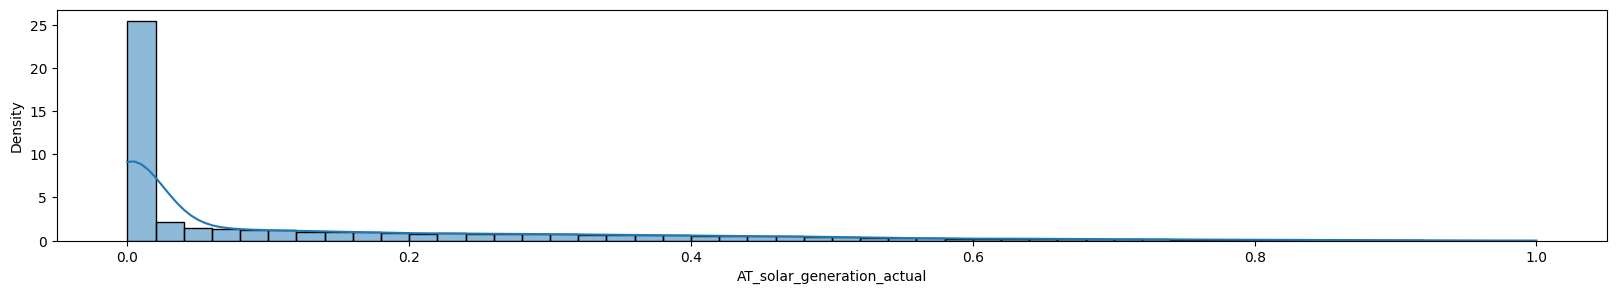

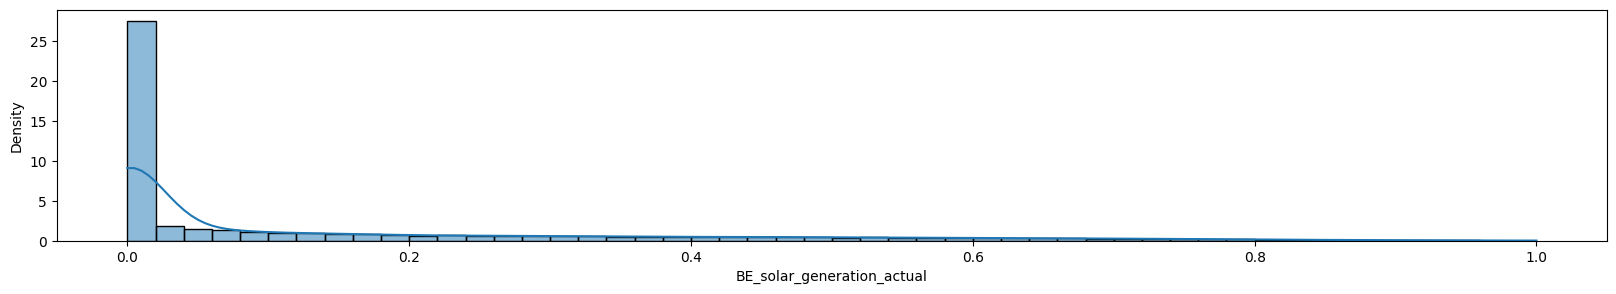

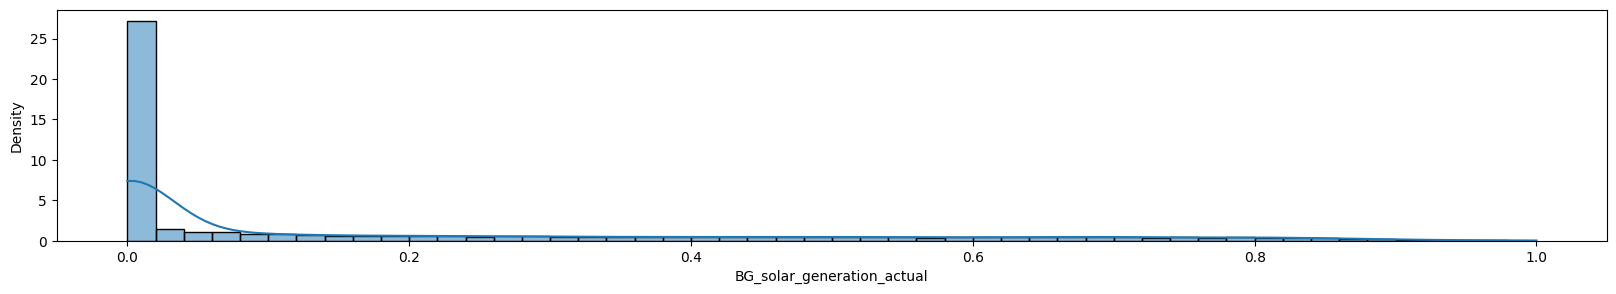

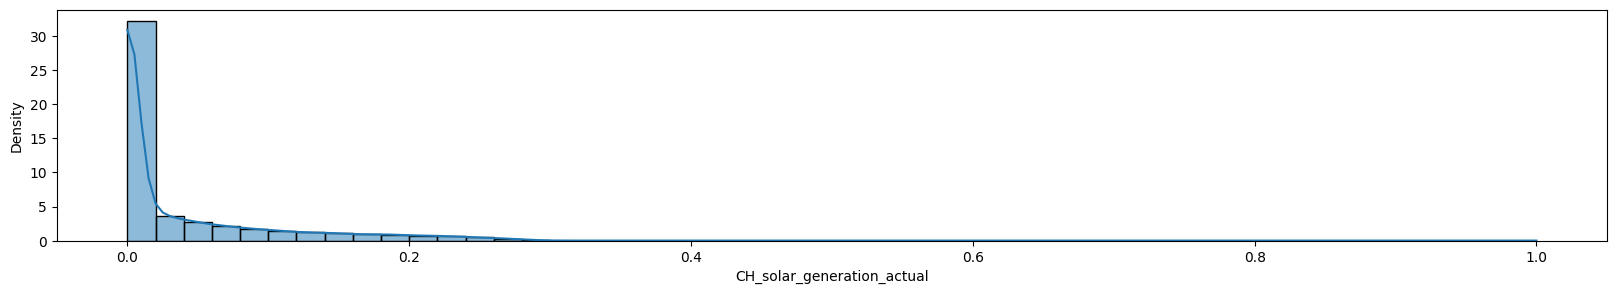

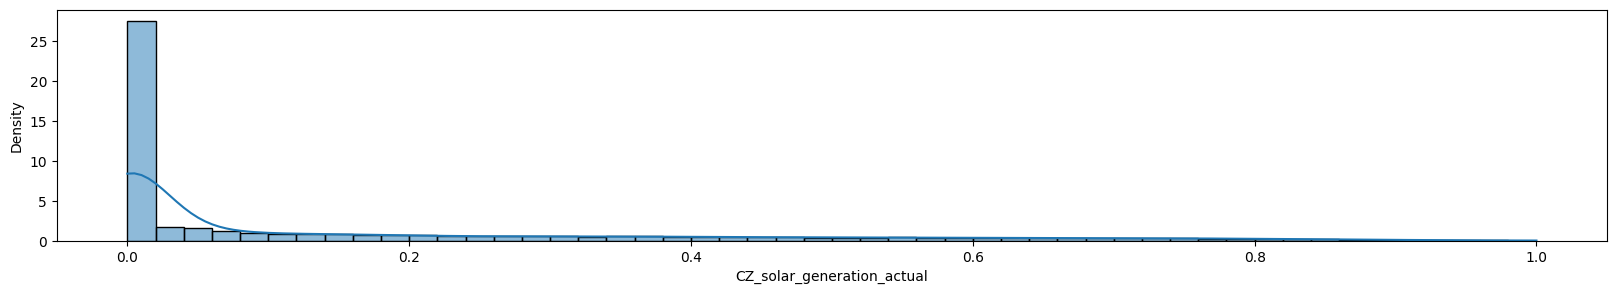

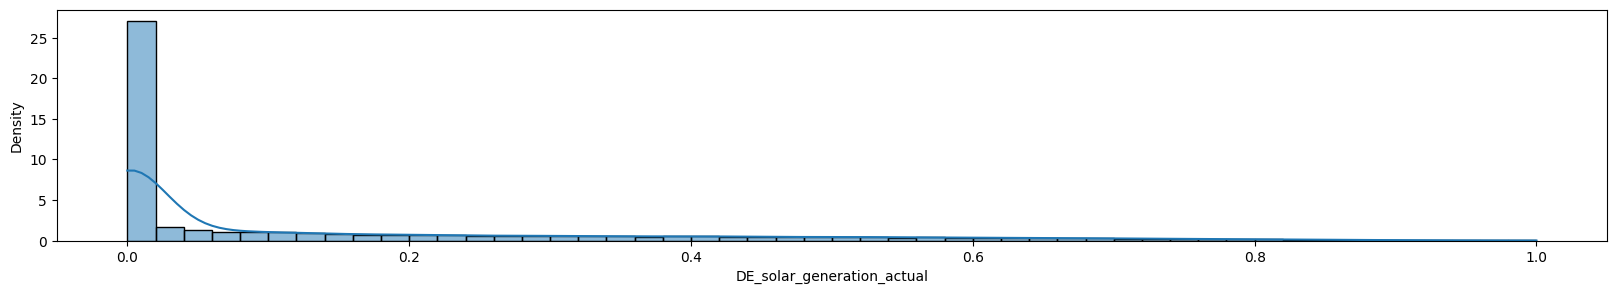

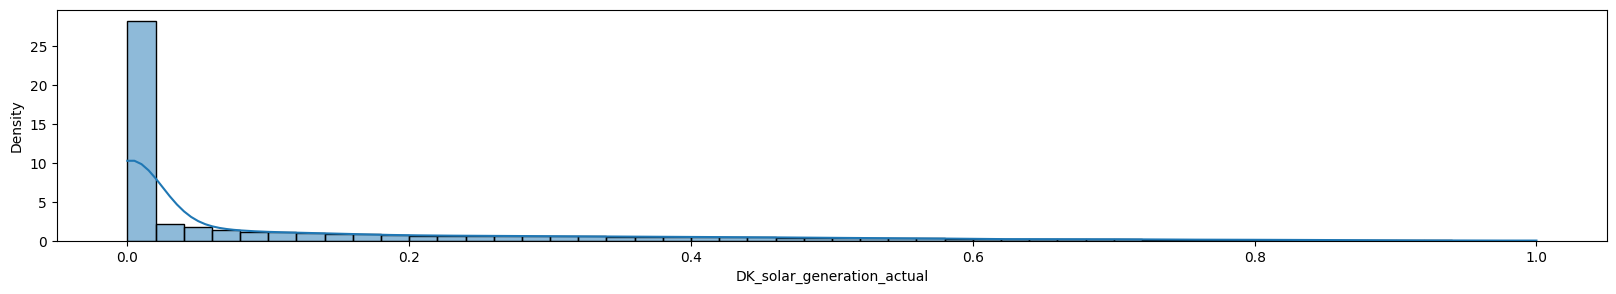

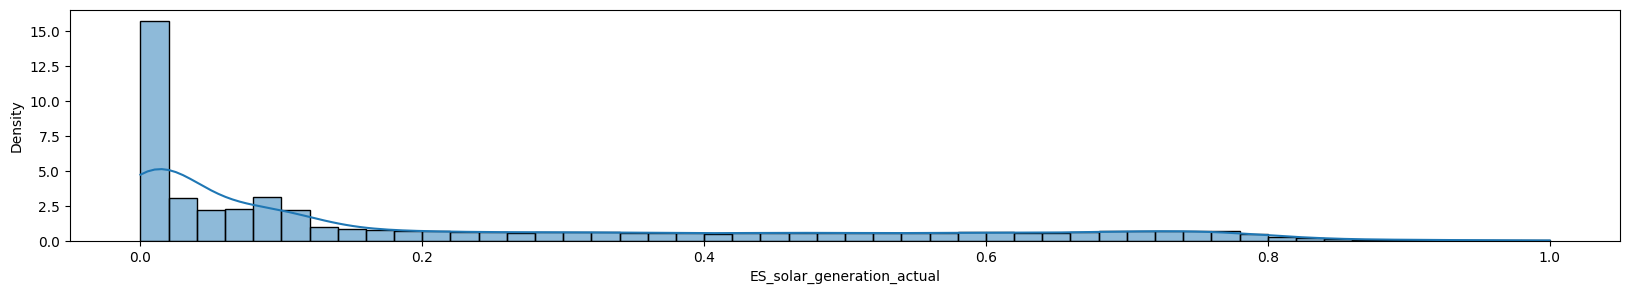

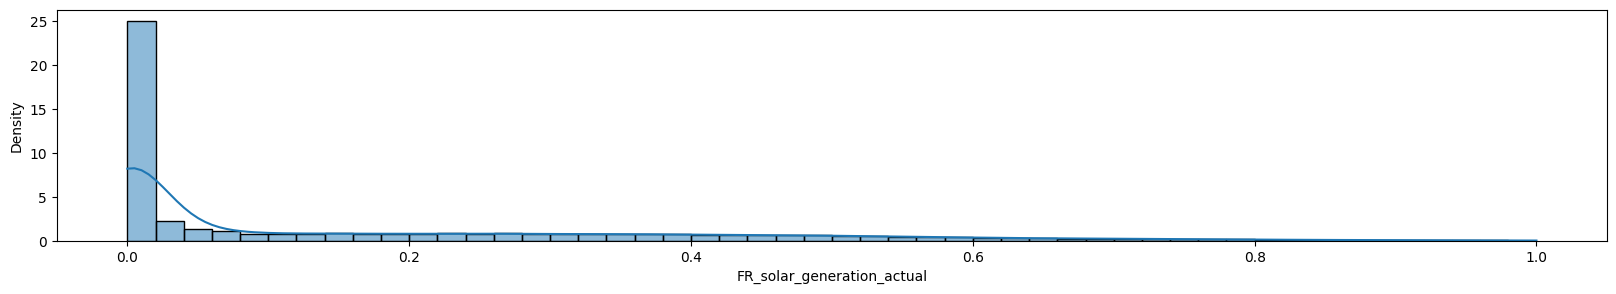

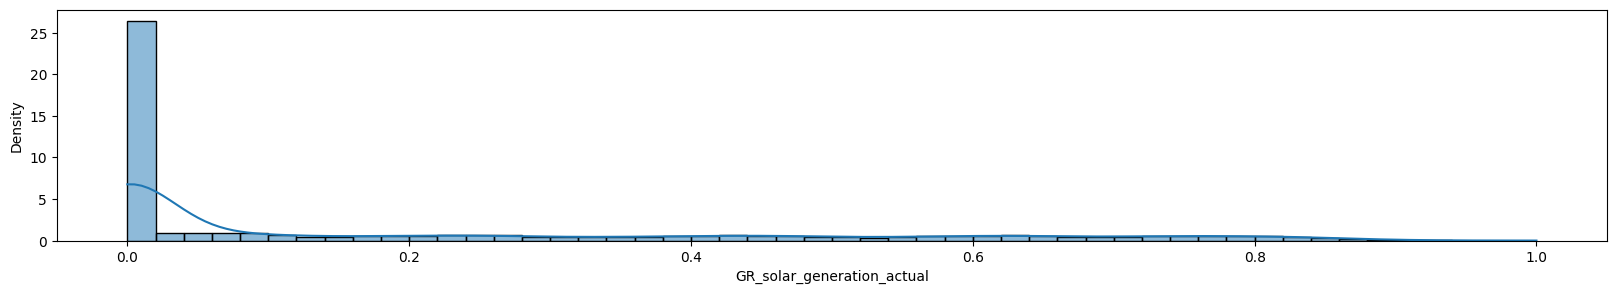

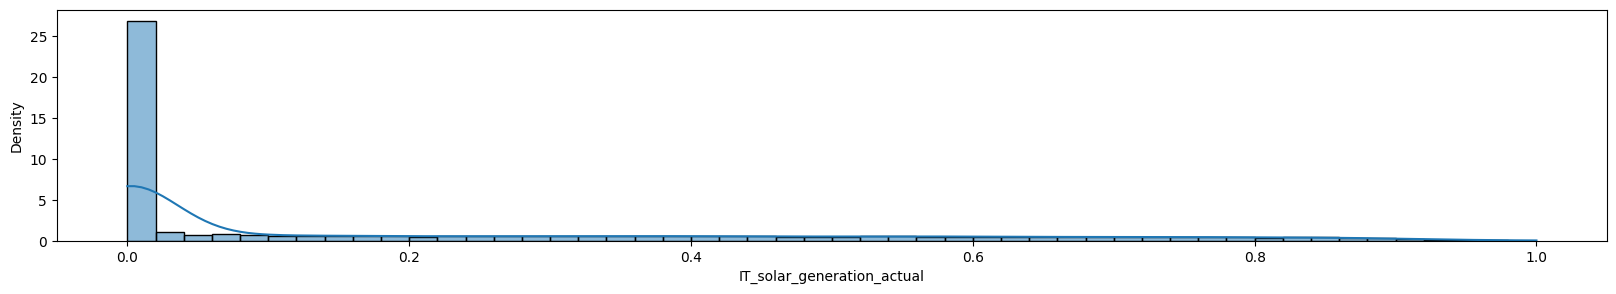

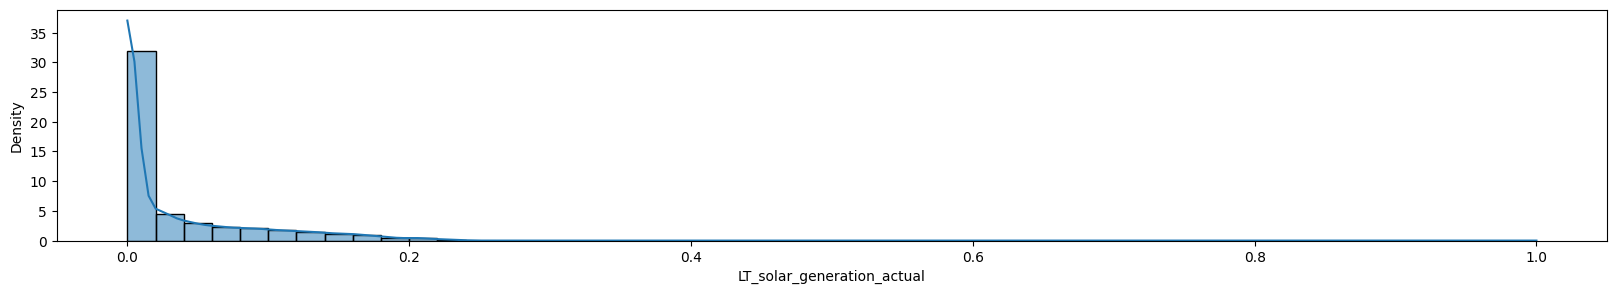

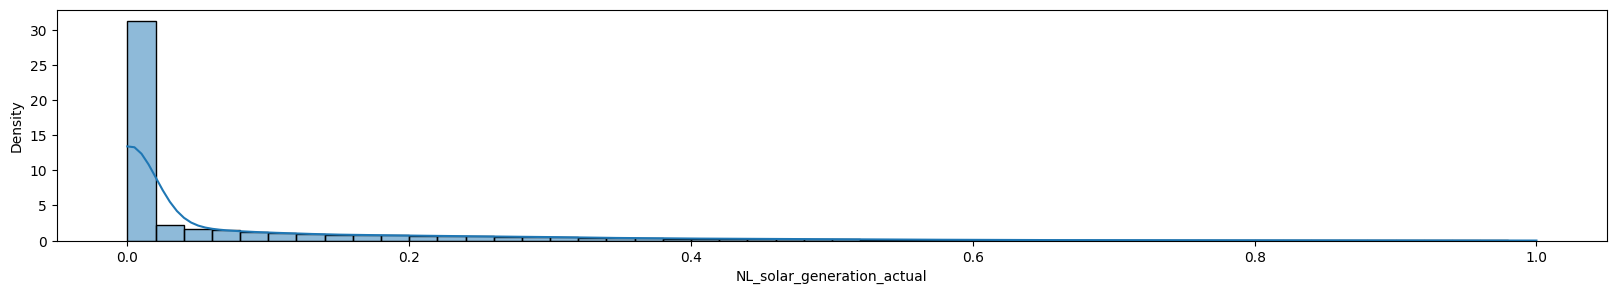

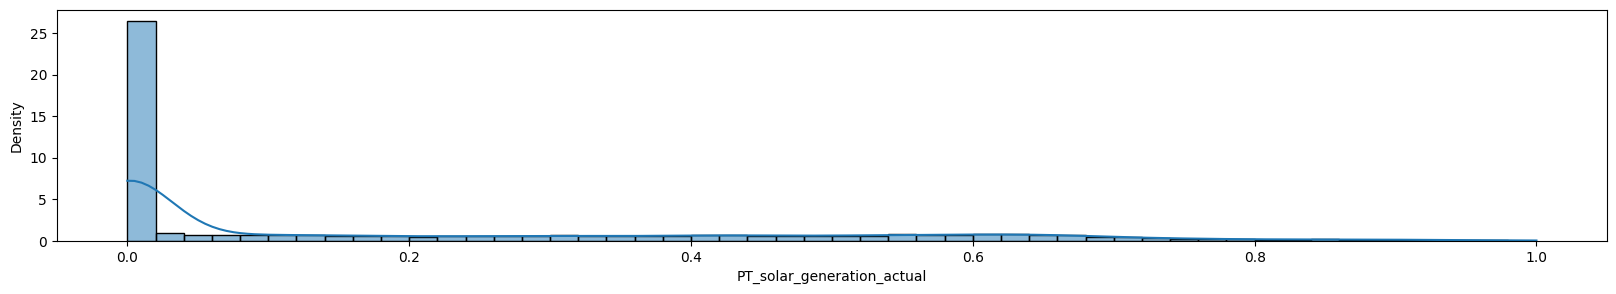

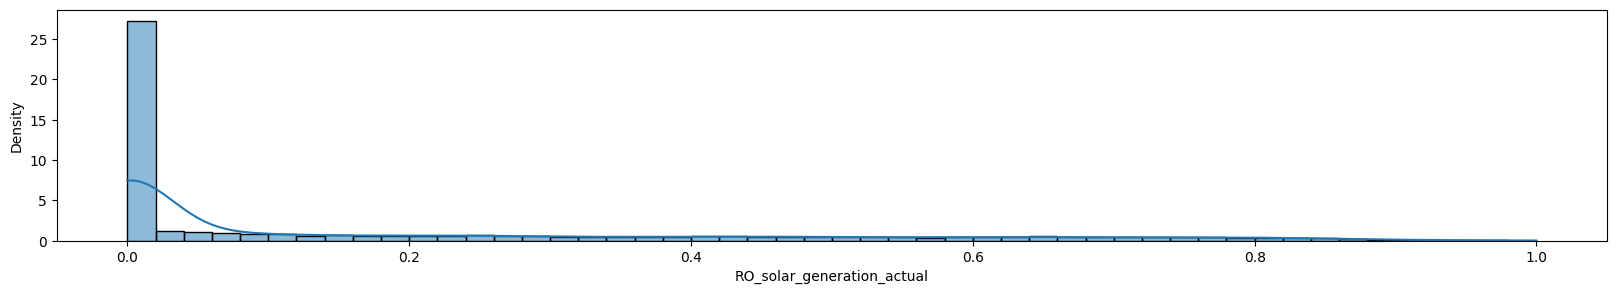

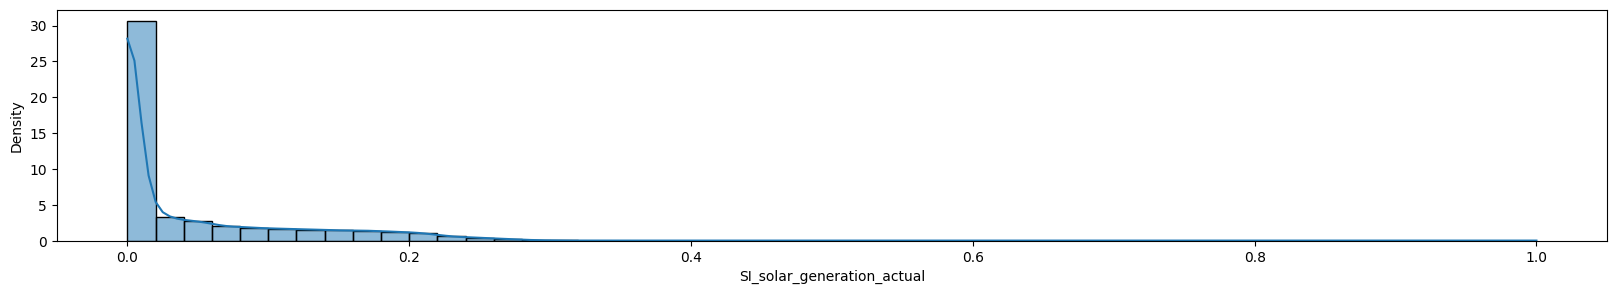

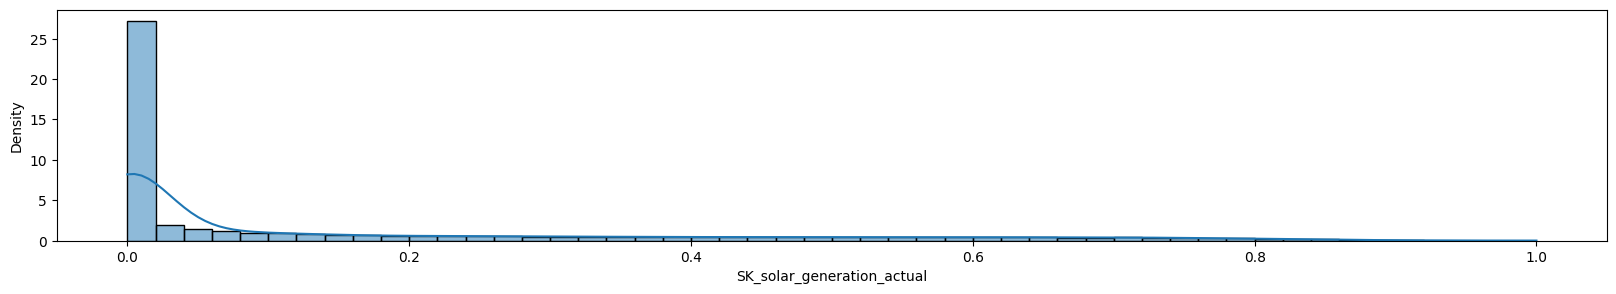

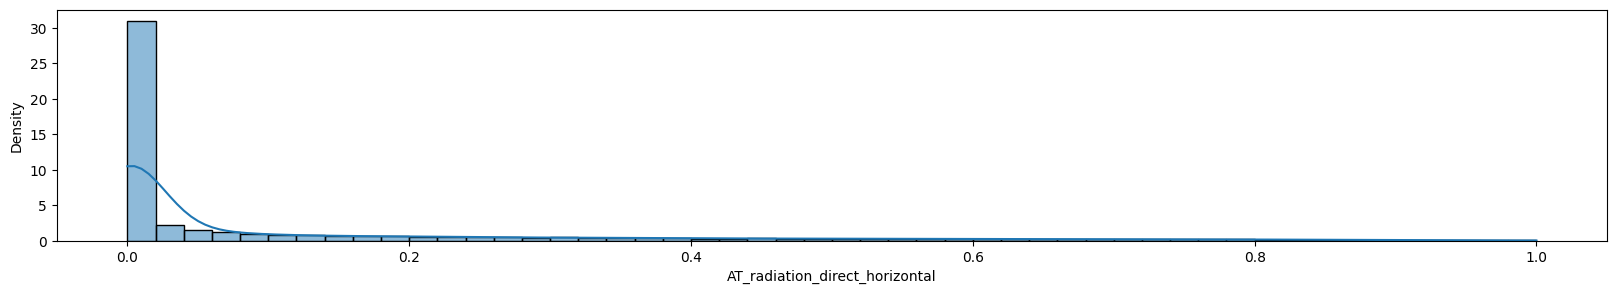

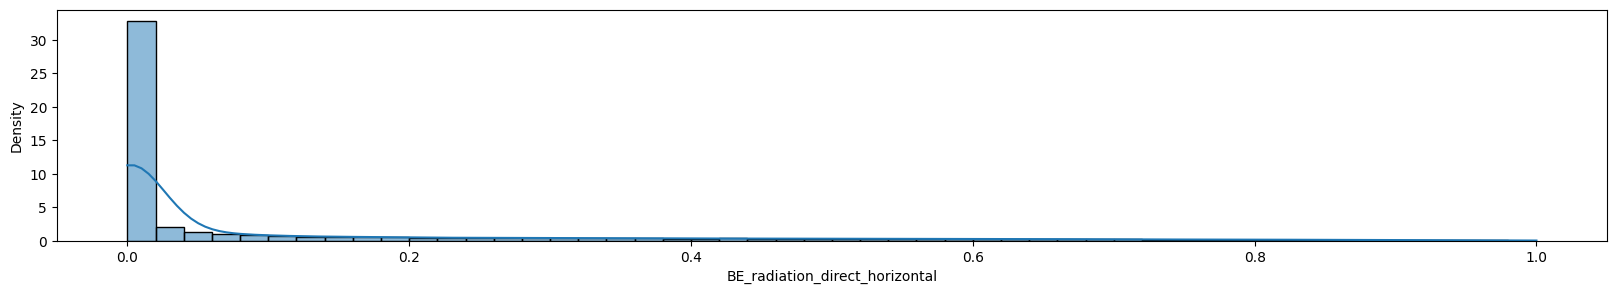

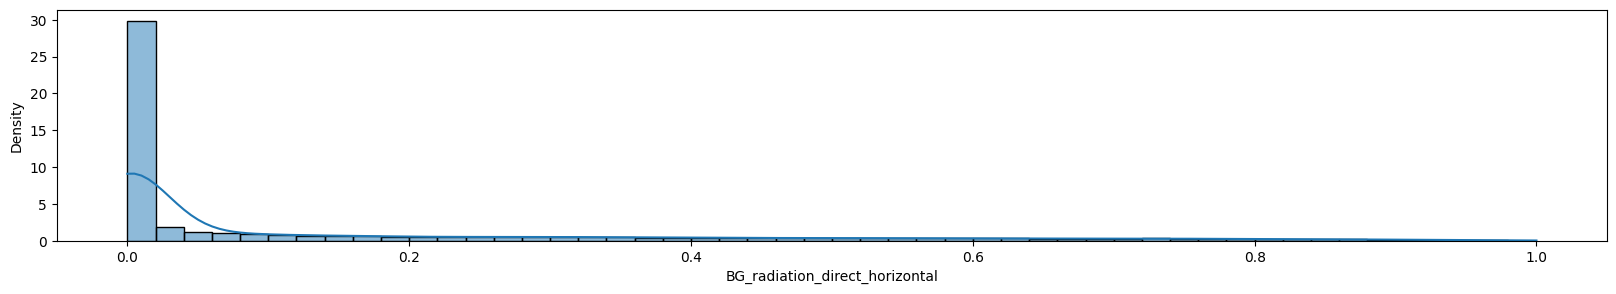

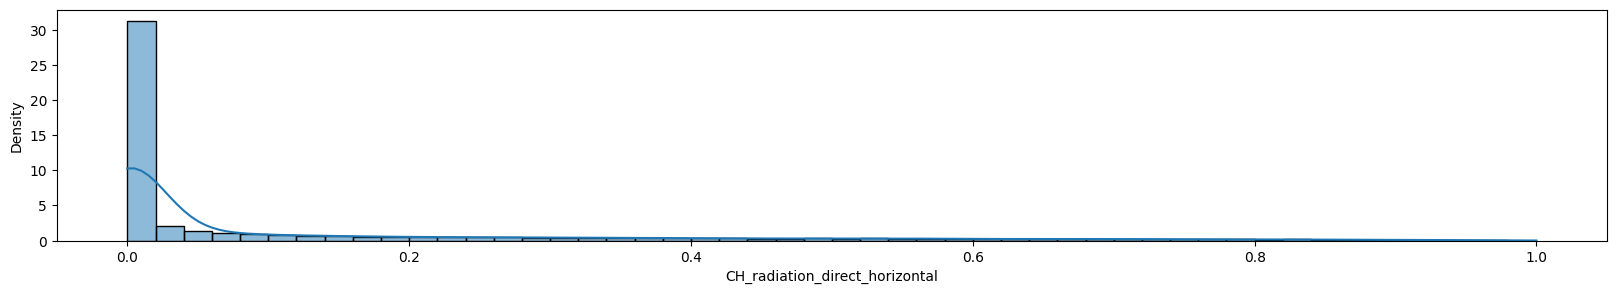

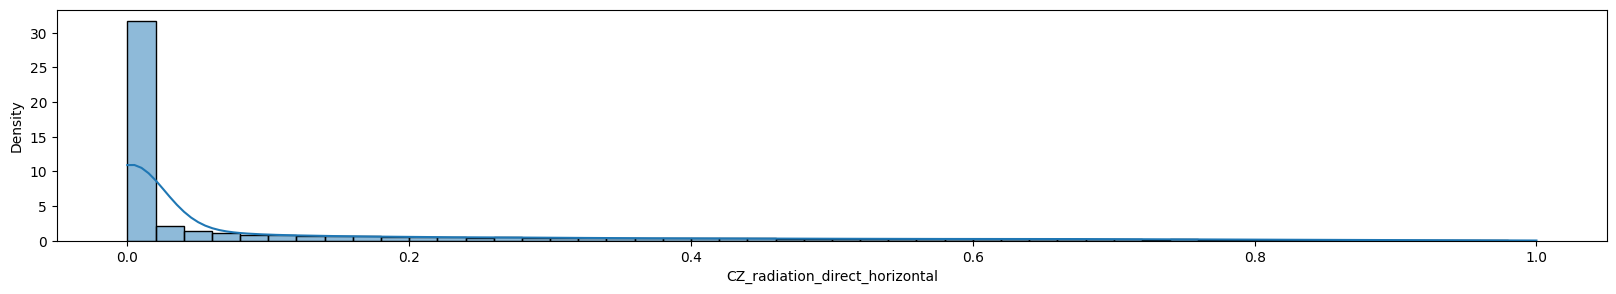

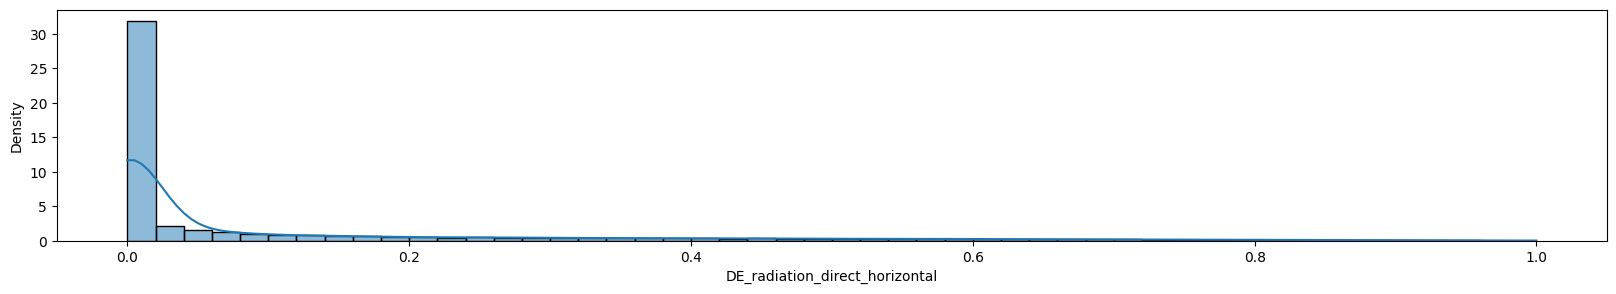

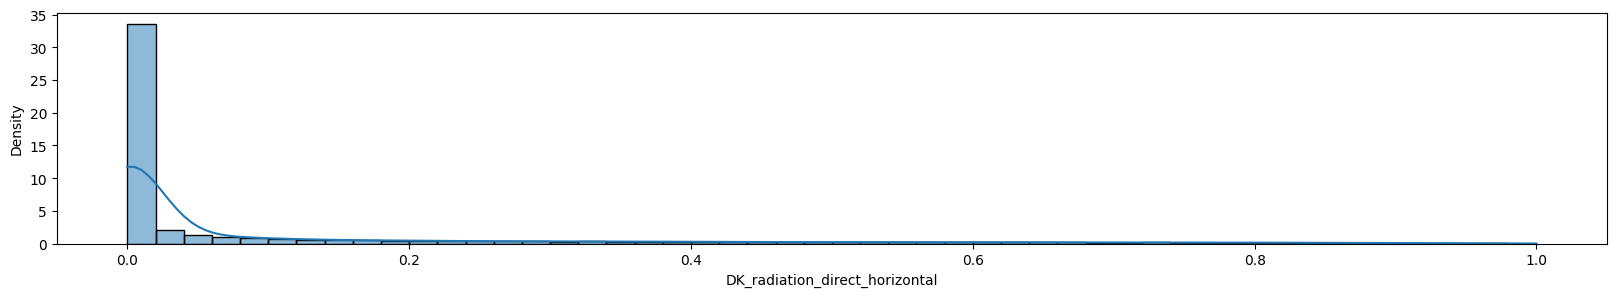

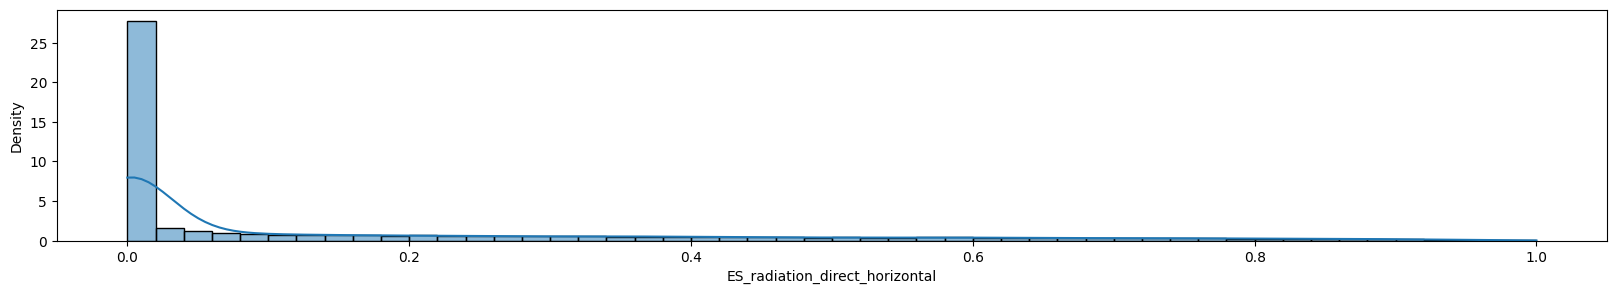

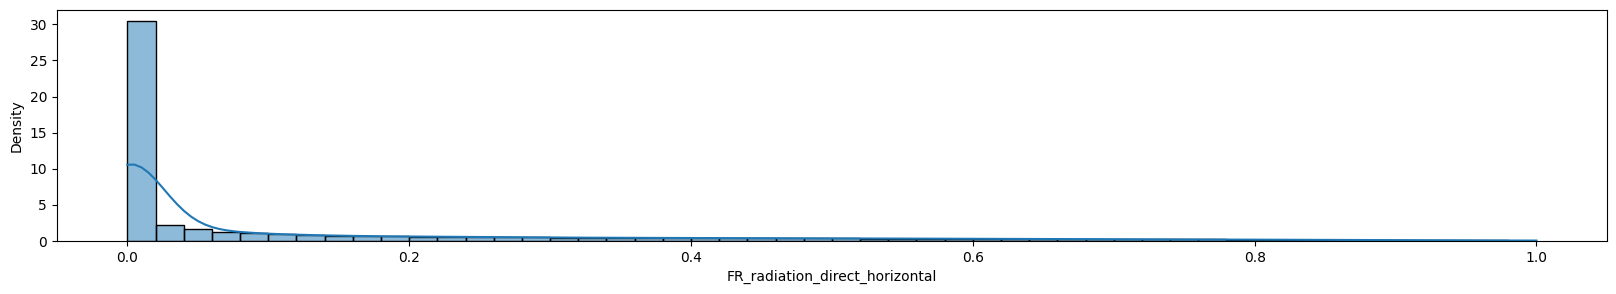

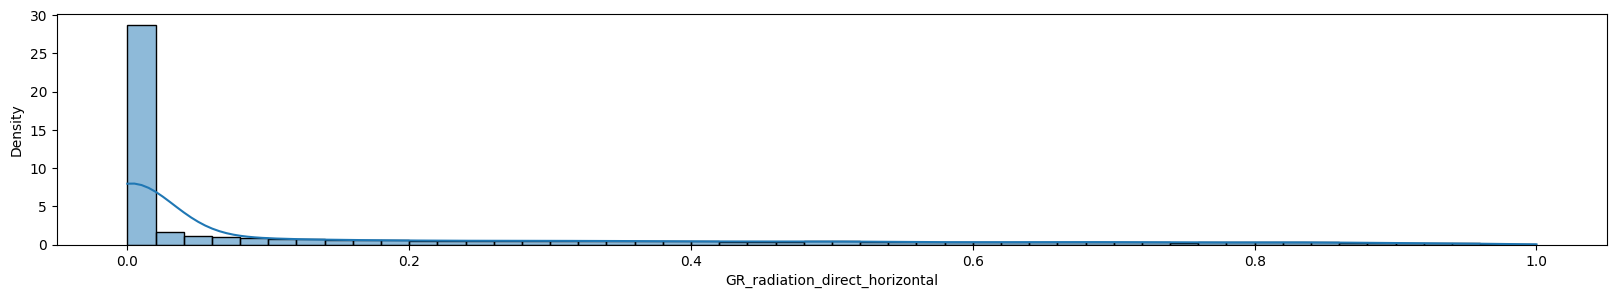

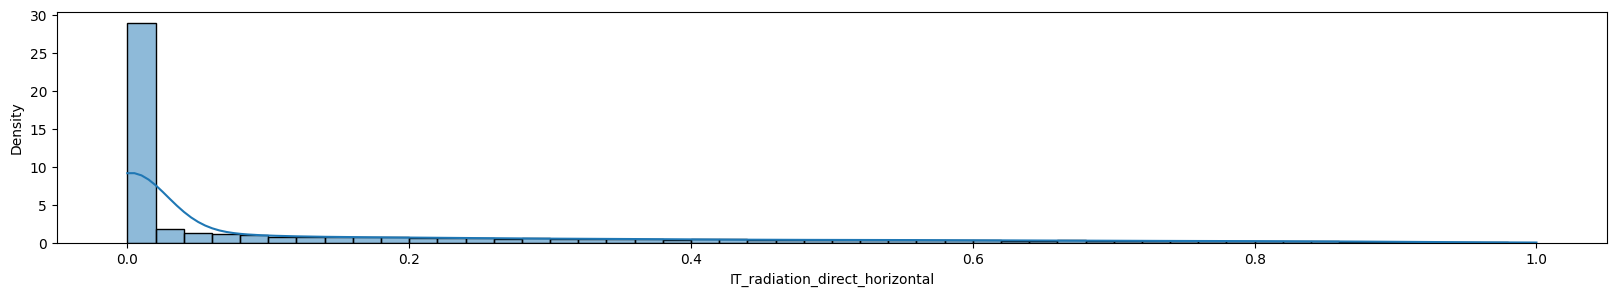

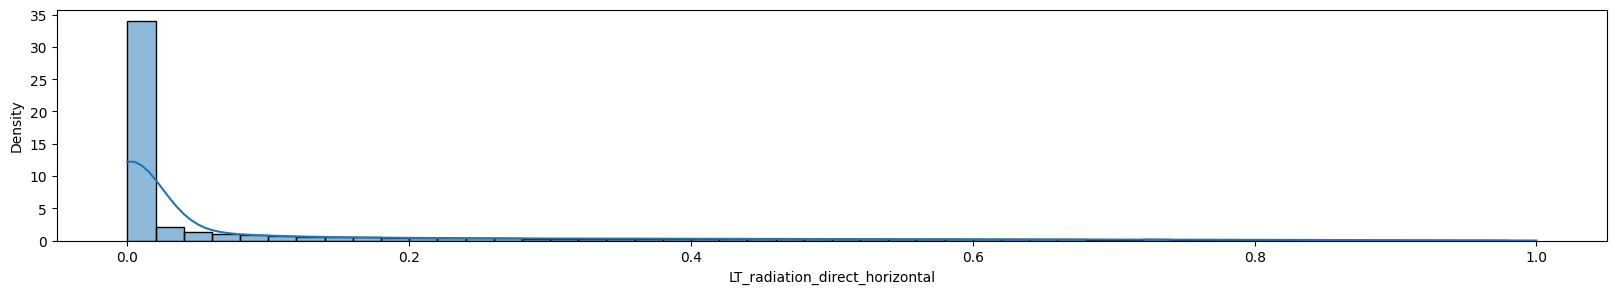

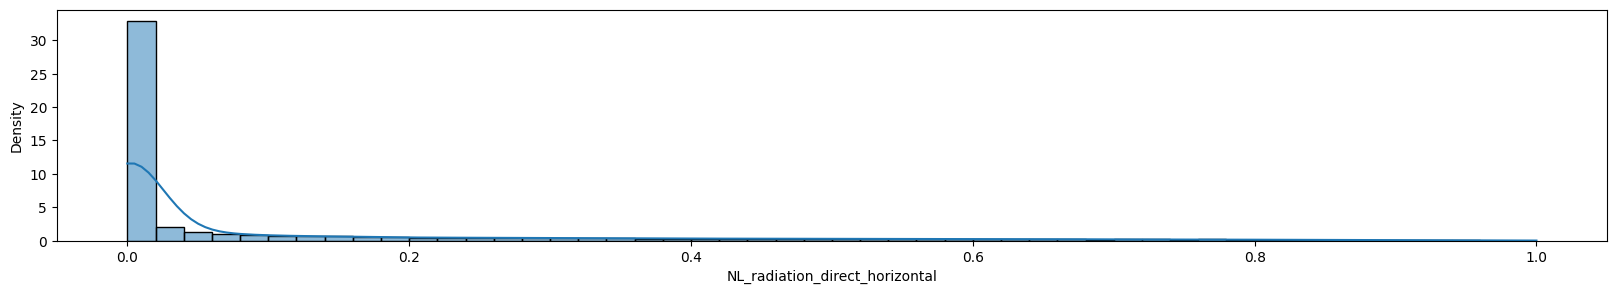

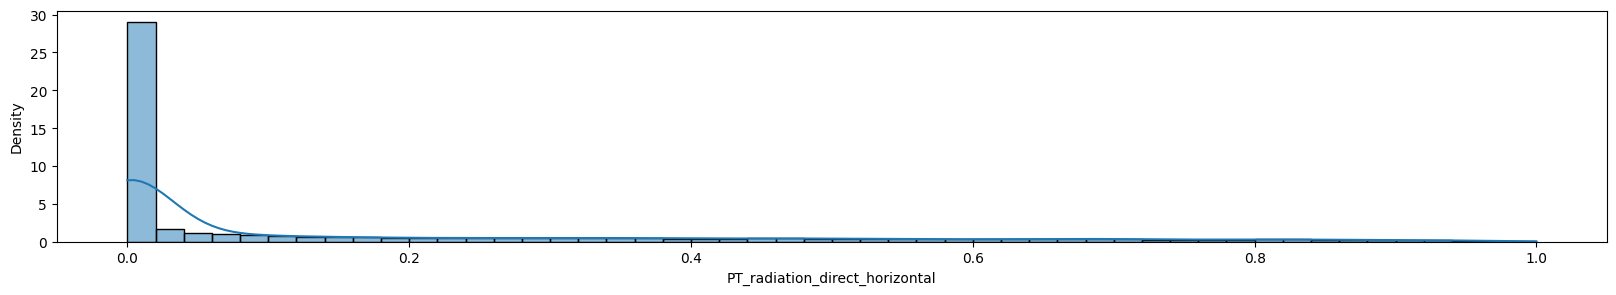

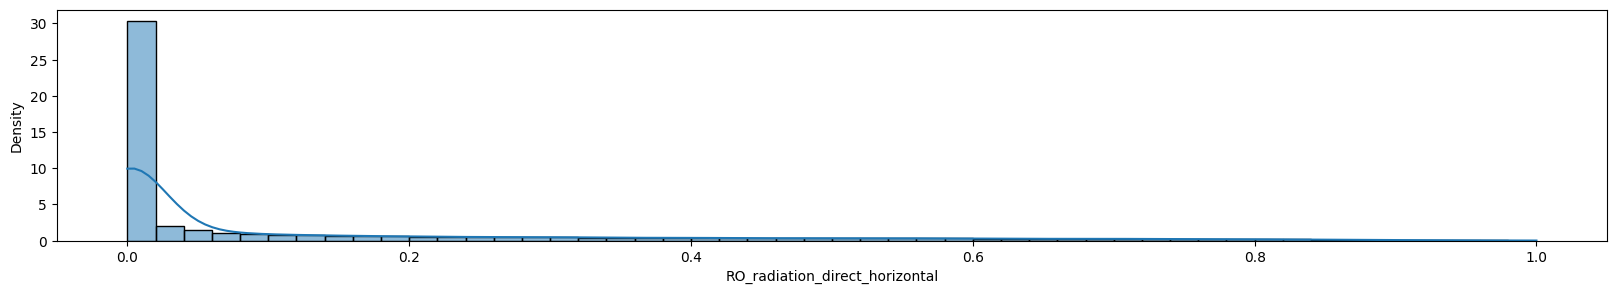

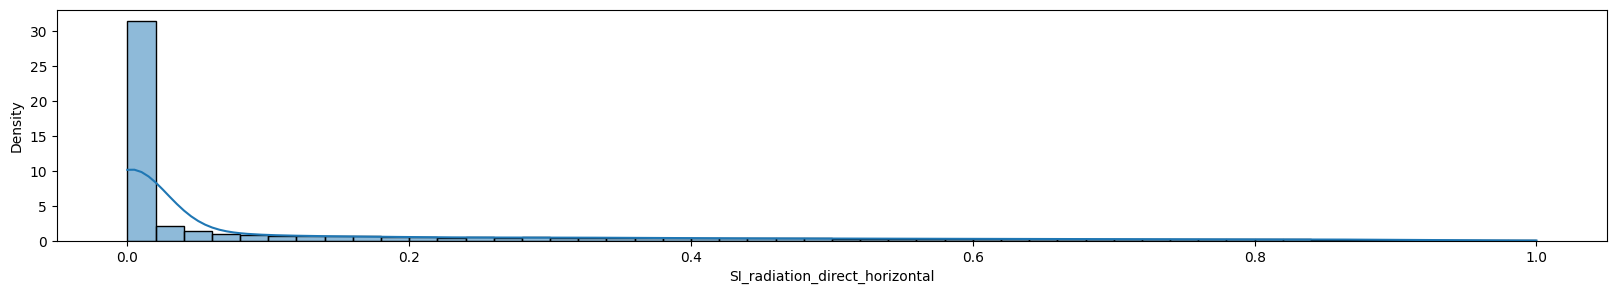

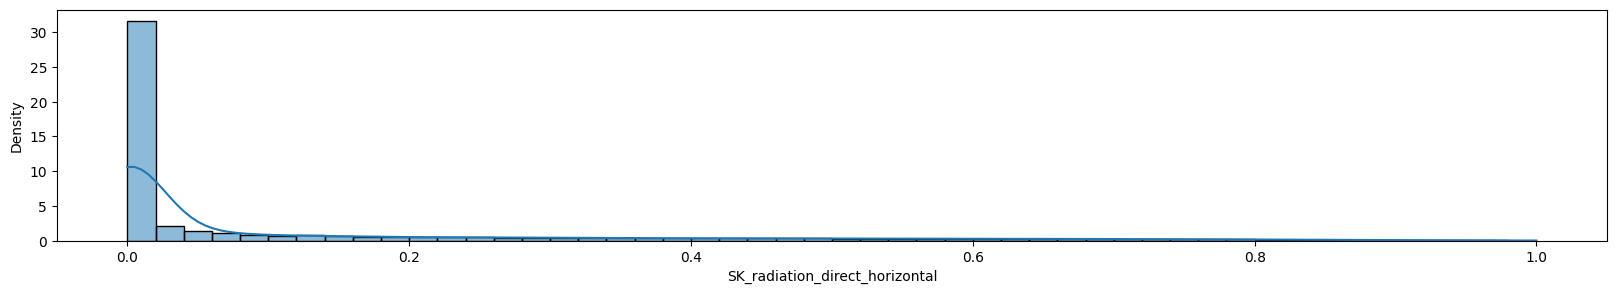

In [26]:
#Plotting solar generation for each country


s_label = []
for feature_name in data.columns:
    if 'month' in feature_name or 'temperature' in feature_name:
        continue;
    sns.histplot(data=data[feature_name], kde=True, label=feature_name, bins=50, stat='density', common_norm=False)
    plt.xlabel(feature_name)
    s_label.append(feature_name)
    plt.show()


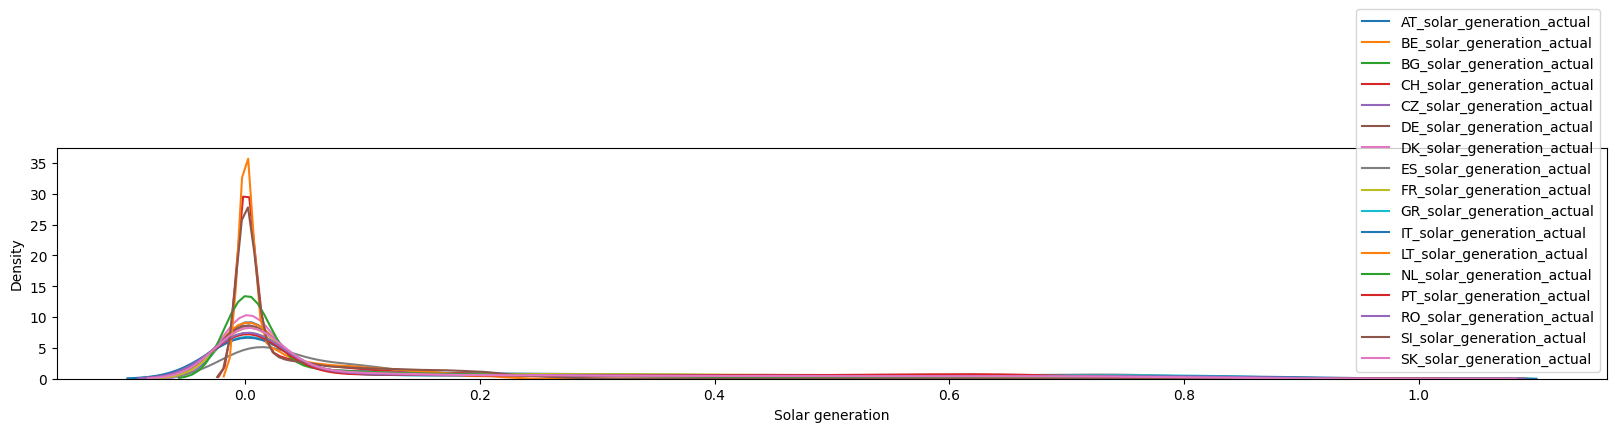

In [27]:
for feature_name in data.columns:
    if 'month' in feature_name or 'temperature' in feature_name or 'radiation' in feature_name:
        continue;
    sns.kdeplot(data=data[feature_name], common_norm=False, label=feature_name)
    plt.xlabel("Solar generation")
    plt.legend(labels=s_label)


In [28]:
for feature_name in data.columns:
    if 'month' in feature_name or 'solar' in feature_name or 'radiation' in feature_name:
        continue;
    print(feature_name, 'mean value: ', data[feature_name].mean())

AT_temperature mean value:  0.5263917922222152
BE_temperature mean value:  0.42554621512988755
BG_temperature mean value:  0.5099765507925557
CH_temperature mean value:  0.5254963458725365
CZ_temperature mean value:  0.4860585746039726
DE_temperature mean value:  0.46800246820883495
DK_temperature mean value:  0.4775899254478574
ES_temperature mean value:  0.45524627160484427
FR_temperature mean value:  0.44563883349012995
GR_temperature mean value:  0.4695431803765857
IT_temperature mean value:  0.46009244754522005
LT_temperature mean value:  0.5212576198422164
NL_temperature mean value:  0.4392885296122689
PT_temperature mean value:  0.41907179943319056
RO_temperature mean value:  0.5150367904928304
SI_temperature mean value:  0.549071766671843
SK_temperature mean value:  0.5204556799518396


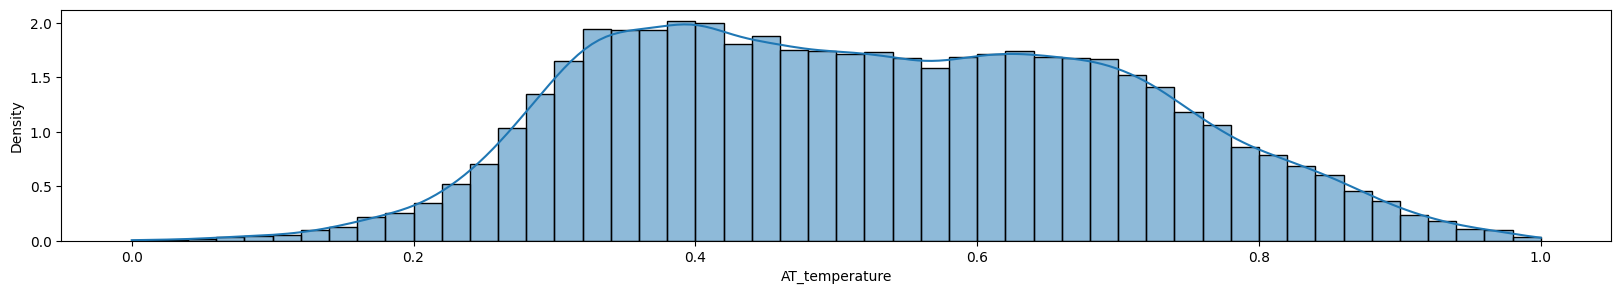

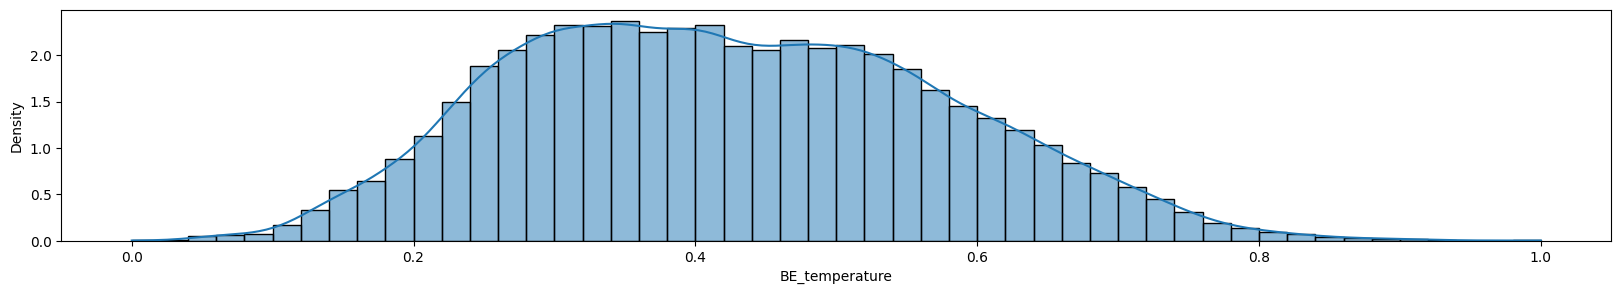

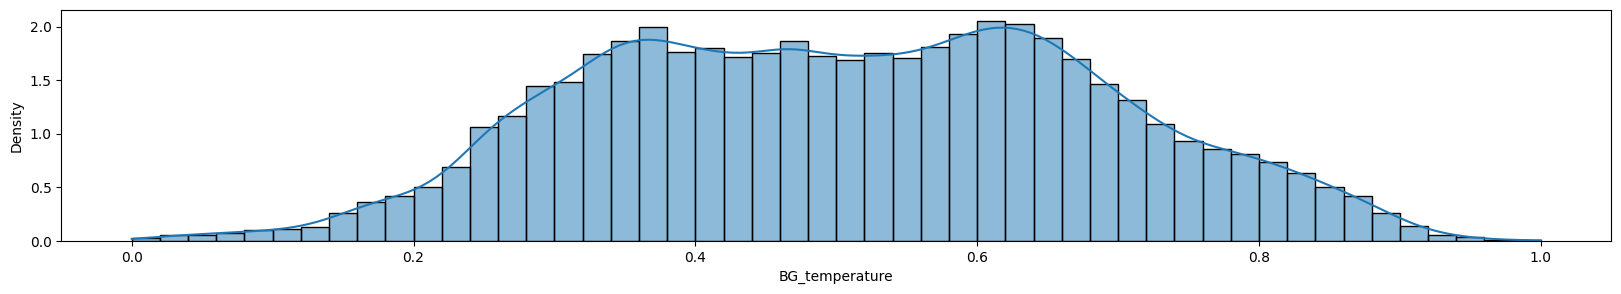

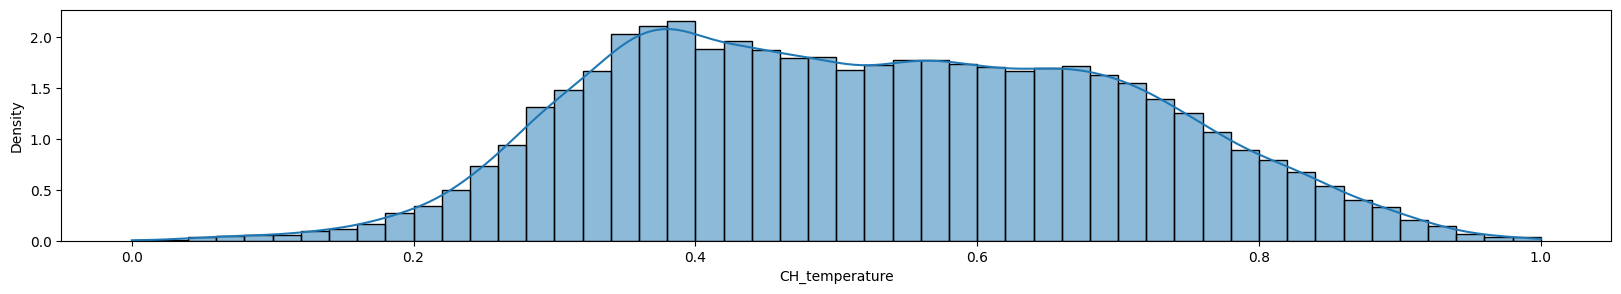

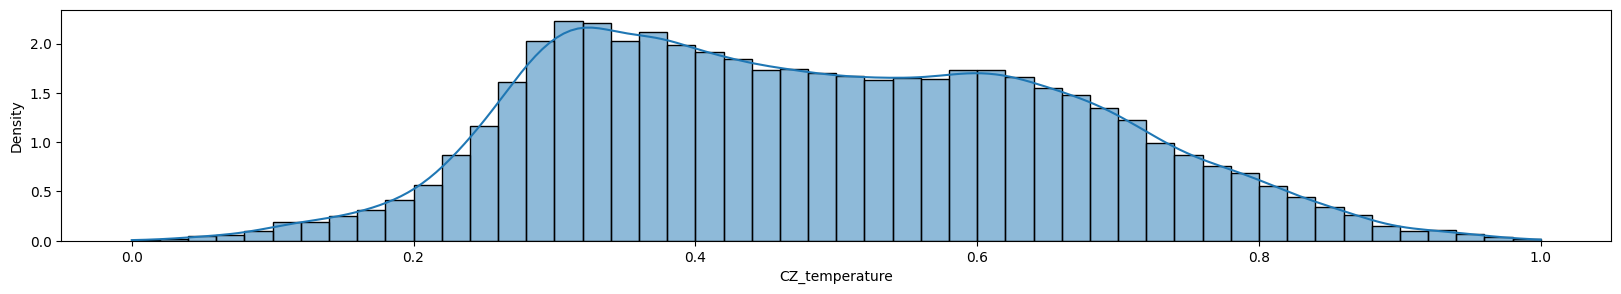

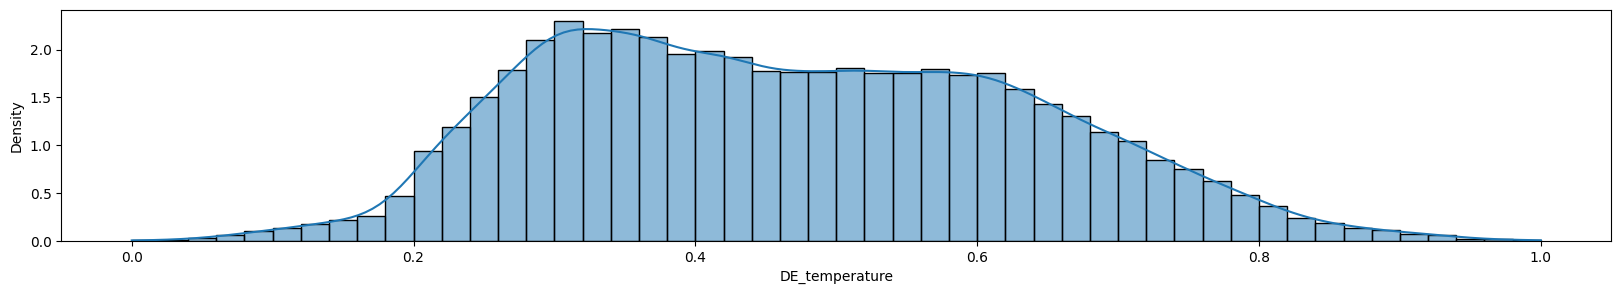

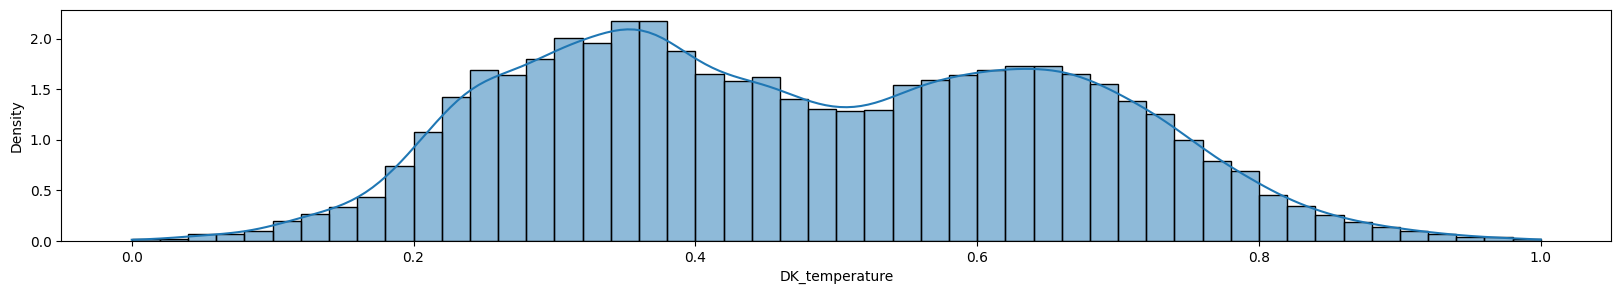

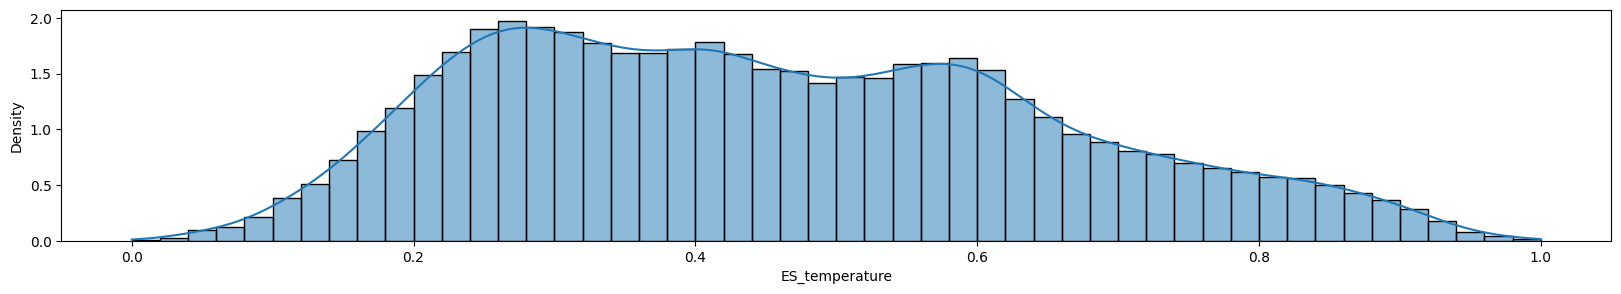

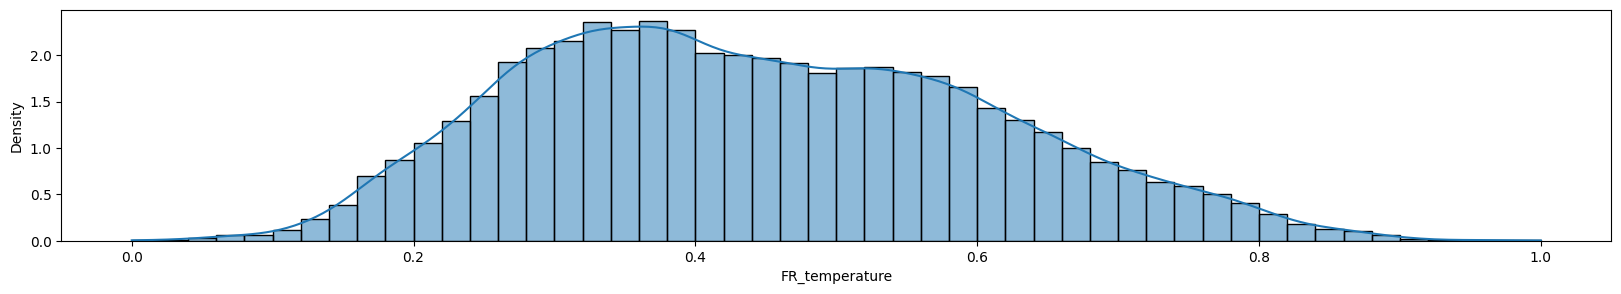

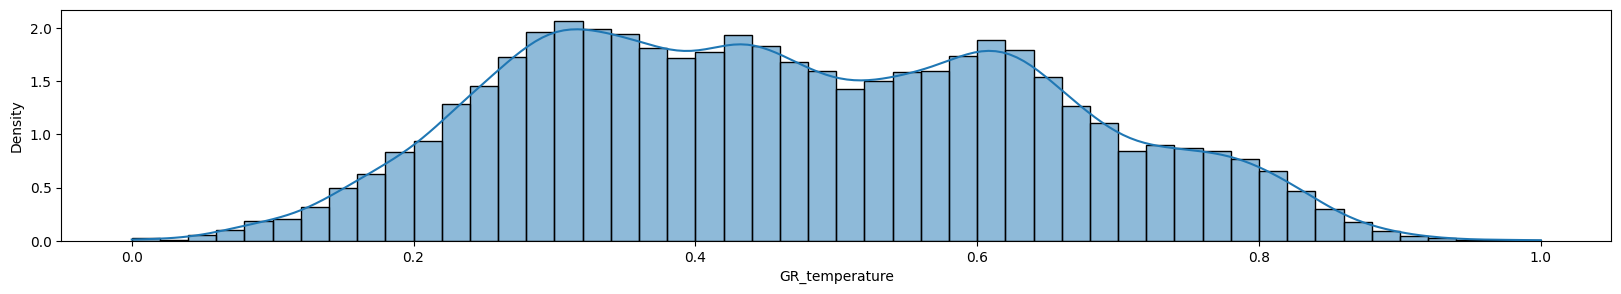

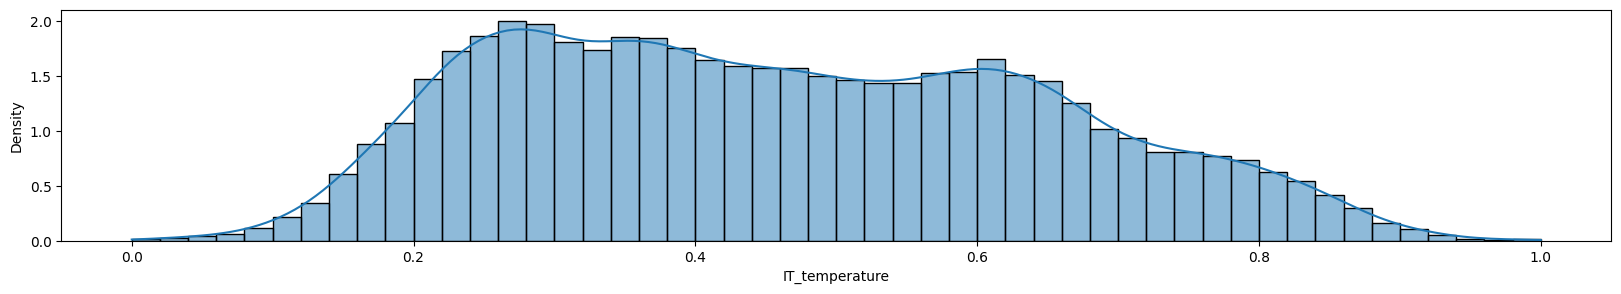

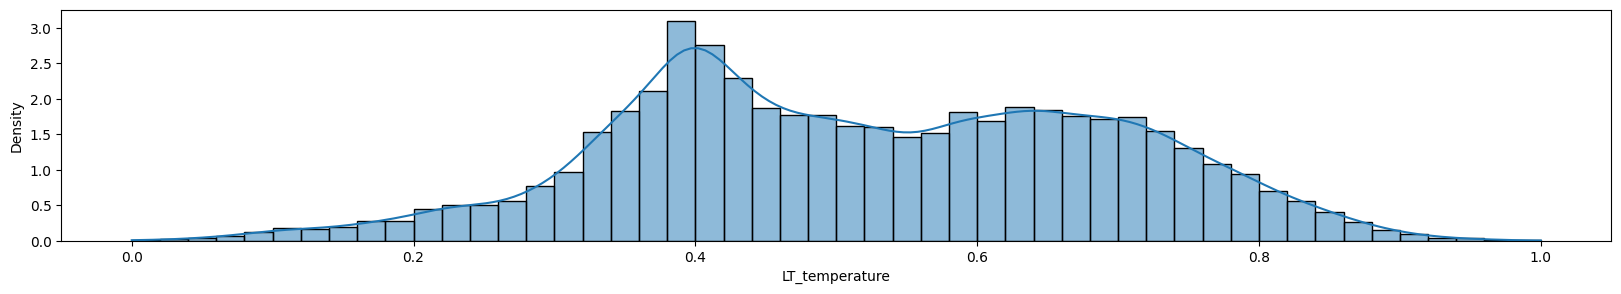

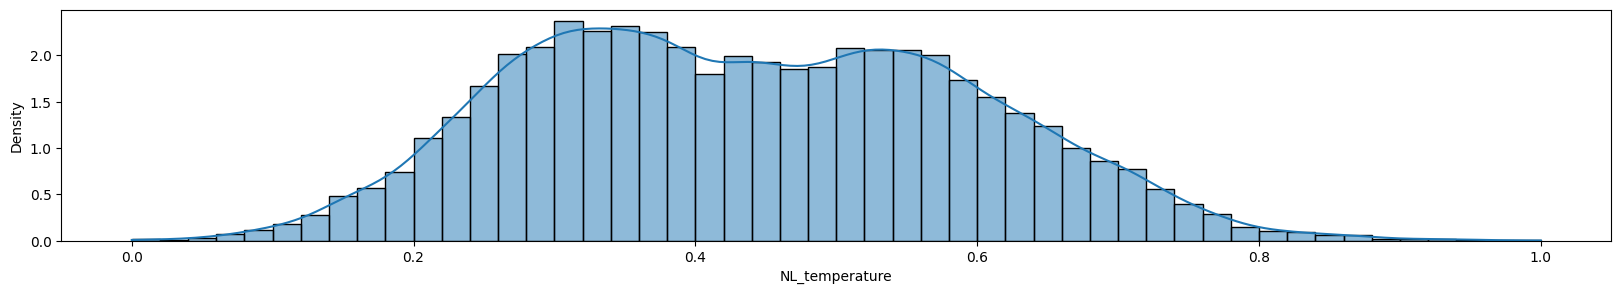

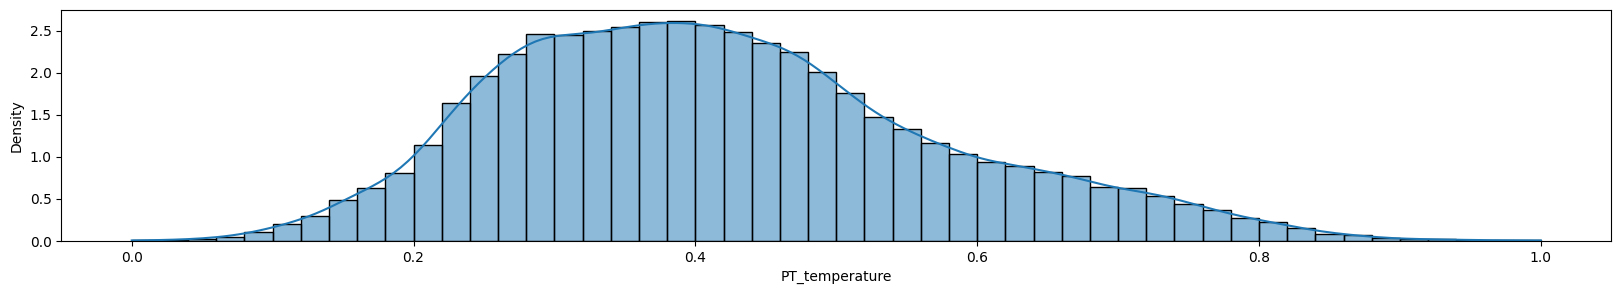

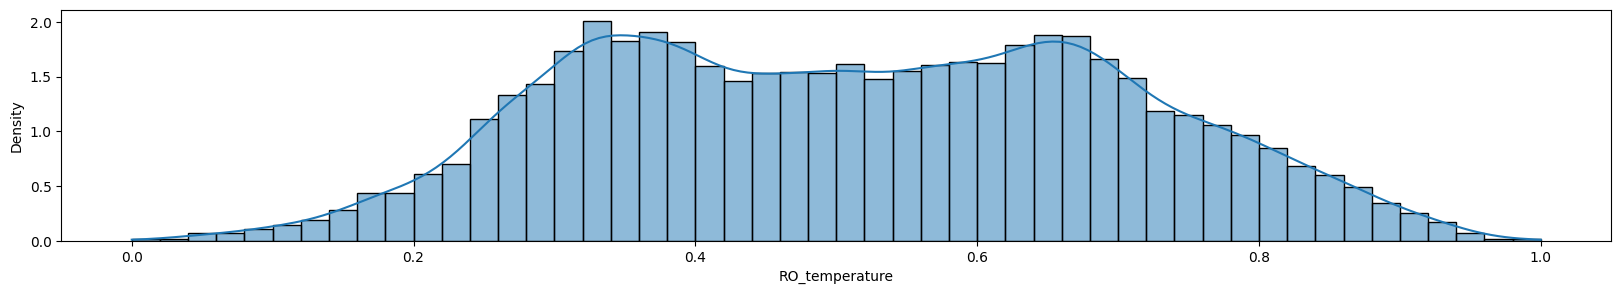

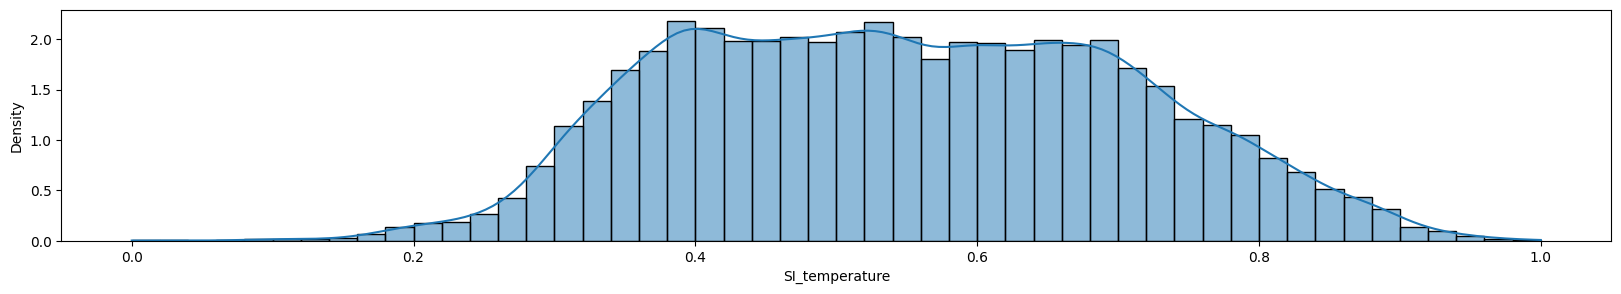

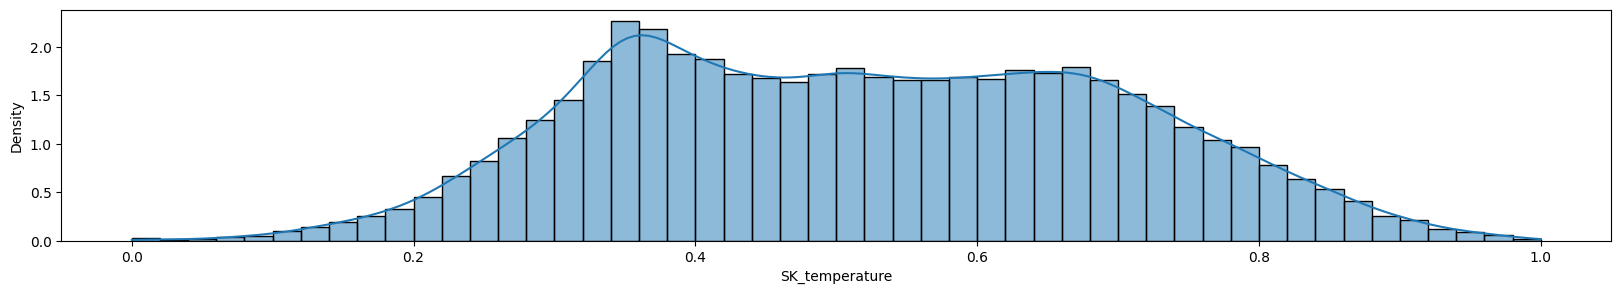

In [29]:
#Plotting temperature for each country


t_label = []
for feature_name in data.columns:
    if 'month' in feature_name or 'solar' in feature_name or 'radiation' in feature_name:
        continue;
    sns.histplot(data=data[feature_name], kde=True, label=feature_name, bins=50, stat='density', common_norm=False)
    plt.xlabel(feature_name)
    t_label.append(feature_name)
    plt.show()


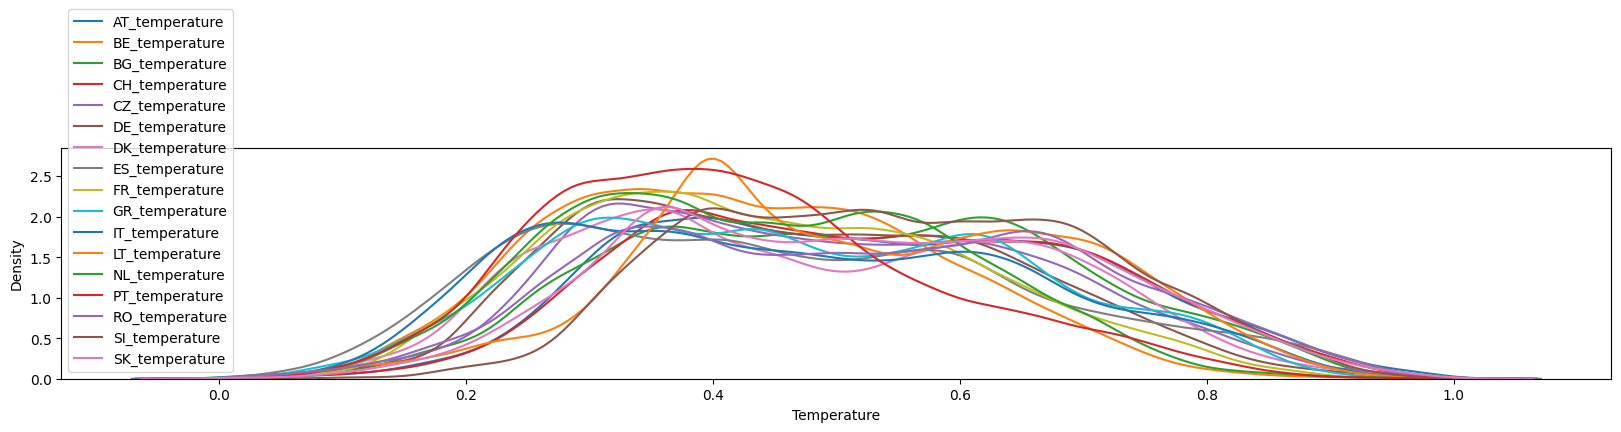

In [30]:
for feature_name in data.columns:
    if 'month' in feature_name or 'solar' in feature_name or 'radiation' in feature_name:
        continue;
    sns.kdeplot(data=data[feature_name], common_norm=False)
    plt.xlabel("Temperature")
    plt.legend(labels=t_label)

In [31]:
for feature_name in data.columns:
    if 'month' in feature_name or 'solar' in feature_name or 'temperature' in feature_name:
        continue;
    print(feature_name, 'mean value: ', data[feature_name].mean())

AT_radiation_direct_horizontal mean value:  0.11090020926911755
BE_radiation_direct_horizontal mean value:  0.10313258473294634
BG_radiation_direct_horizontal mean value:  0.1349457954552364
CH_radiation_direct_horizontal mean value:  0.11476242338162448
CZ_radiation_direct_horizontal mean value:  0.10640276653114601
DE_radiation_direct_horizontal mean value:  0.09836475400264307
DK_radiation_direct_horizontal mean value:  0.09560691055745757
ES_radiation_direct_horizontal mean value:  0.15803601629822775
FR_radiation_direct_horizontal mean value:  0.11107186538263077
GR_radiation_direct_horizontal mean value:  0.15783454803822355
IT_radiation_direct_horizontal mean value:  0.1332304428240991
LT_radiation_direct_horizontal mean value:  0.09190020086519547
NL_radiation_direct_horizontal mean value:  0.0996609116519565
PT_radiation_direct_horizontal mean value:  0.15520371642347777
RO_radiation_direct_horizontal mean value:  0.12051692867151124
SI_radiation_direct_horizontal mean value: 

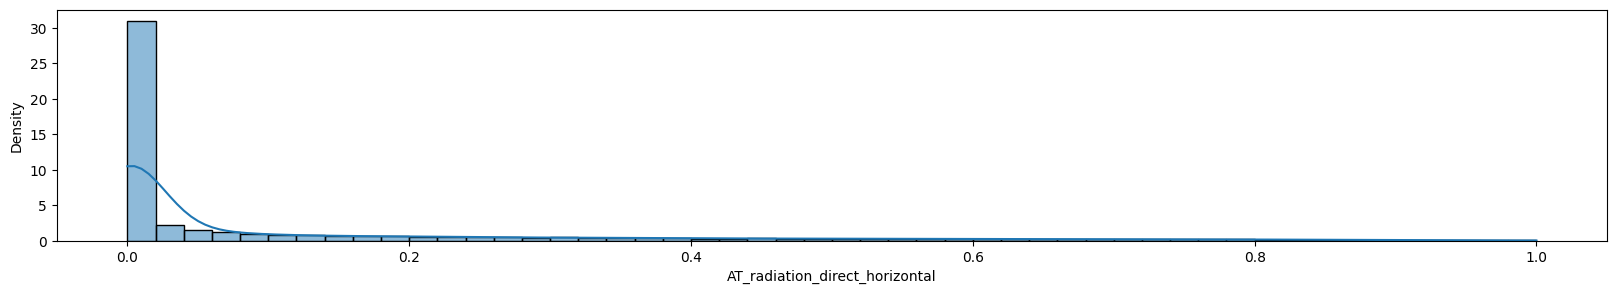

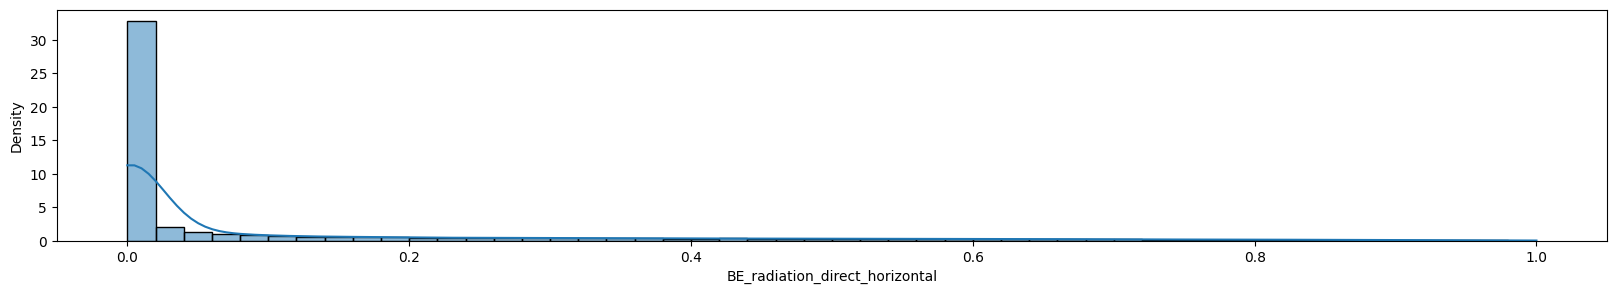

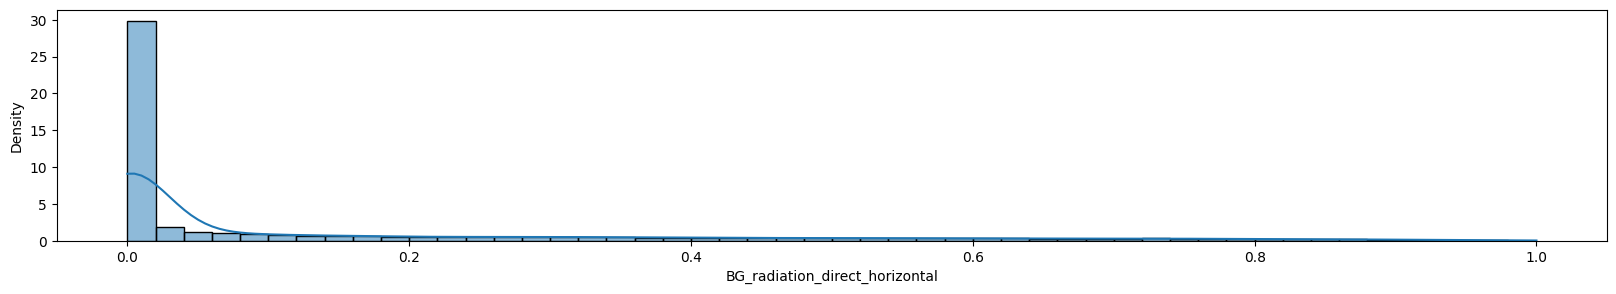

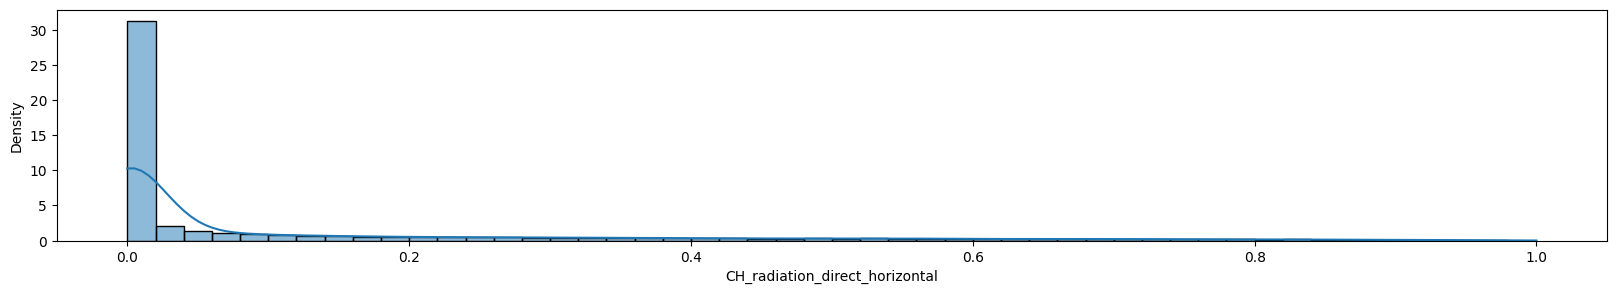

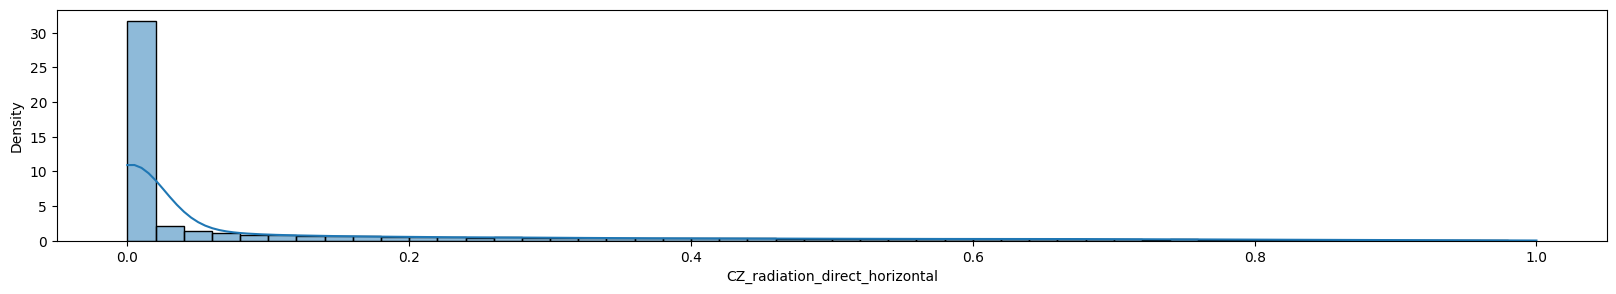

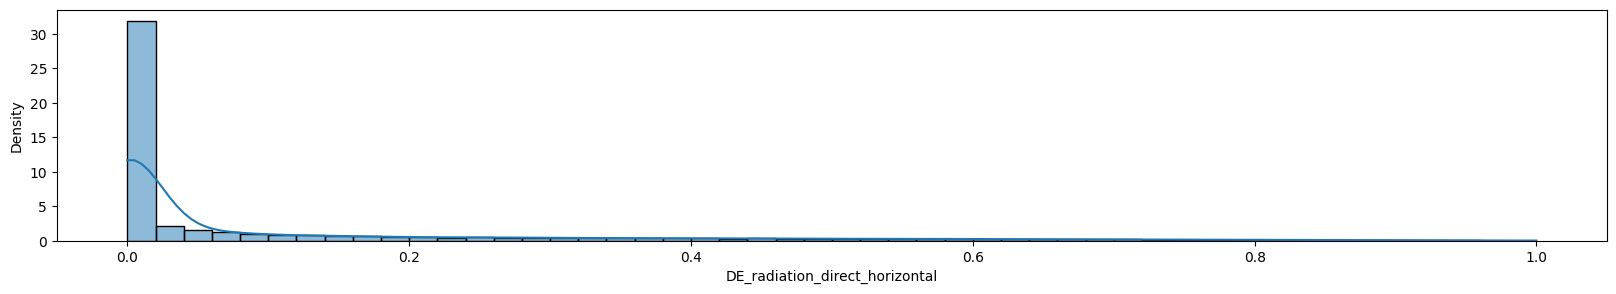

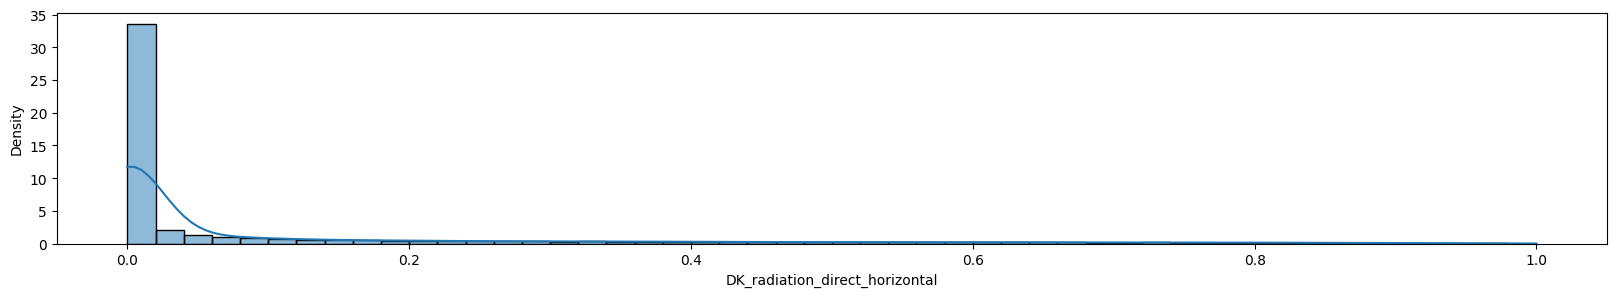

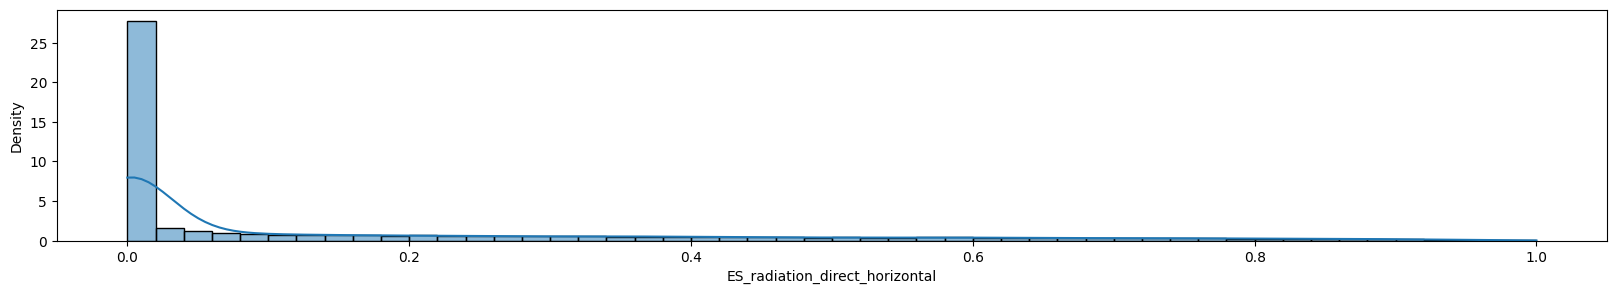

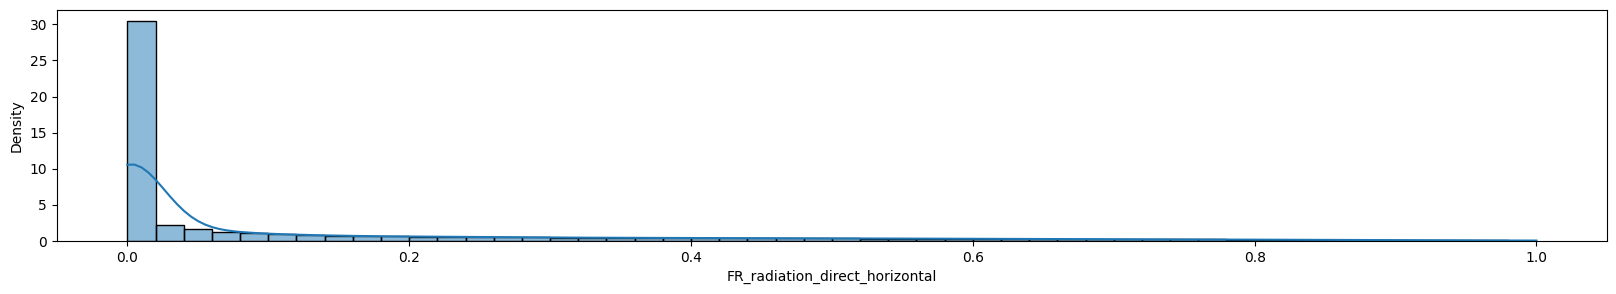

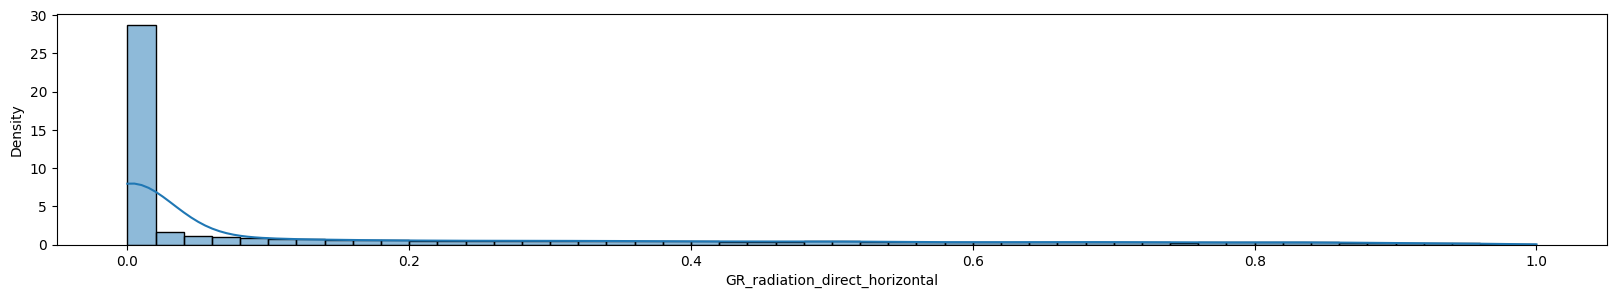

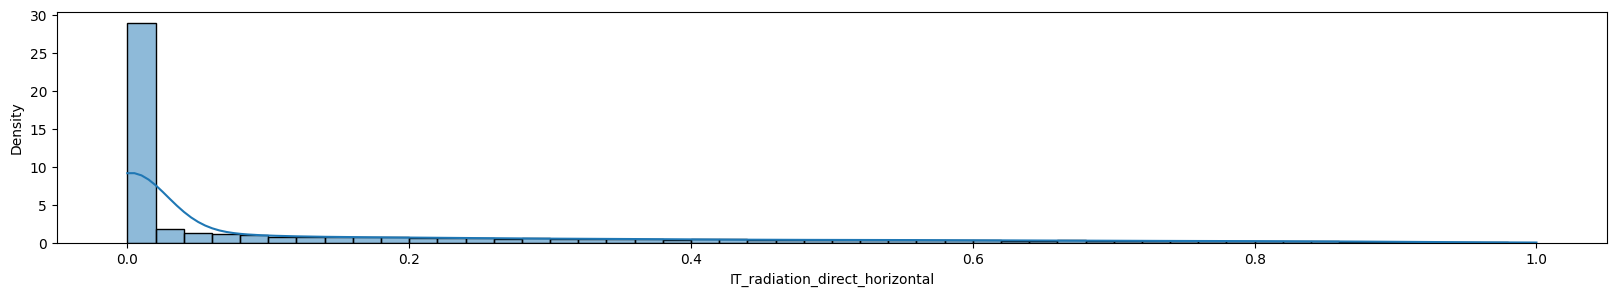

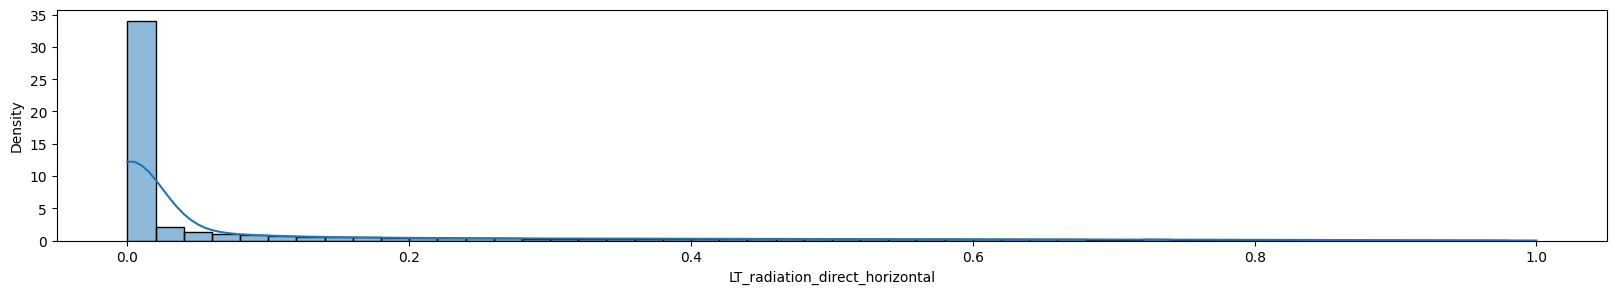

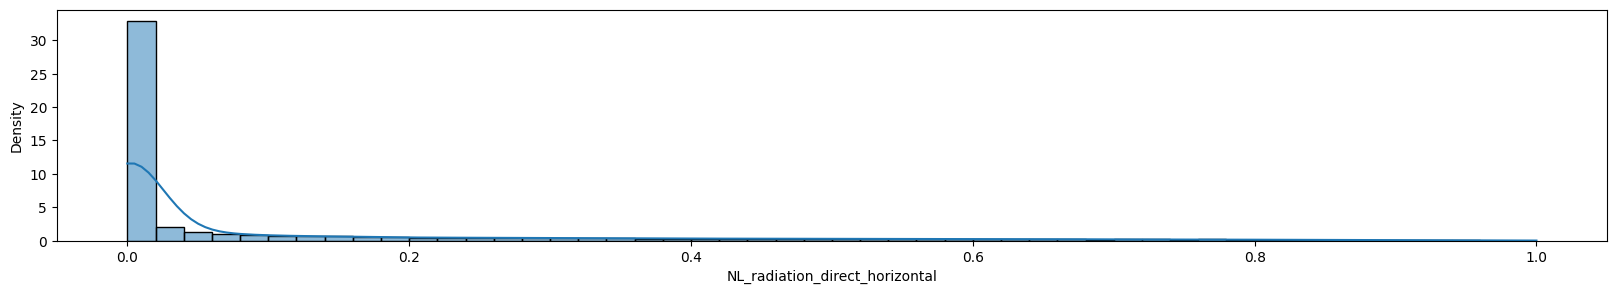

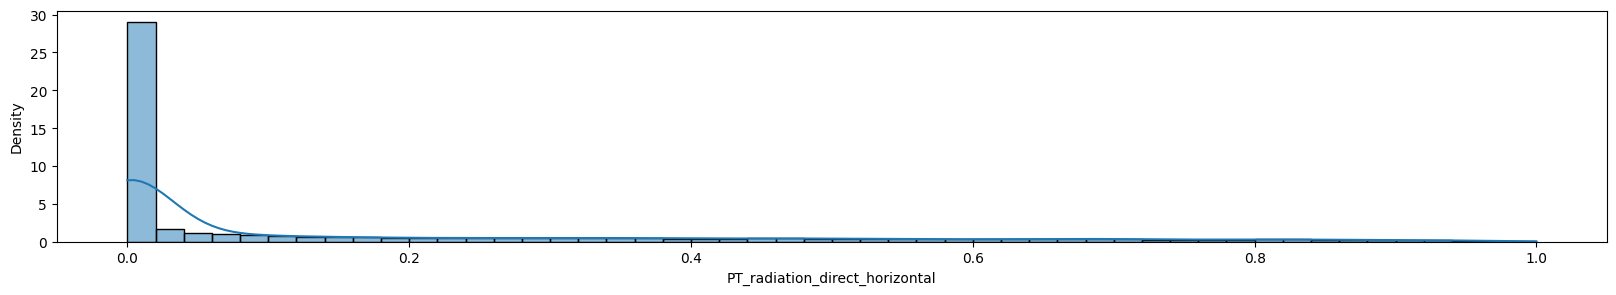

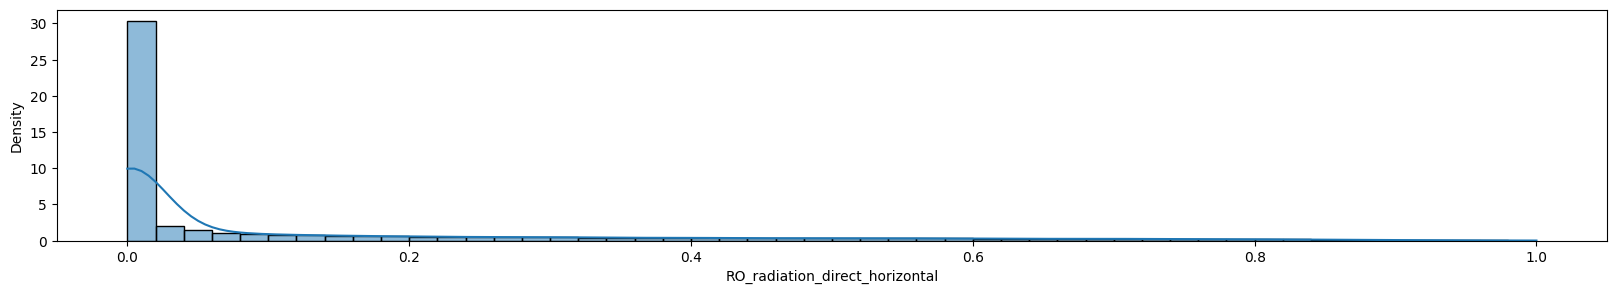

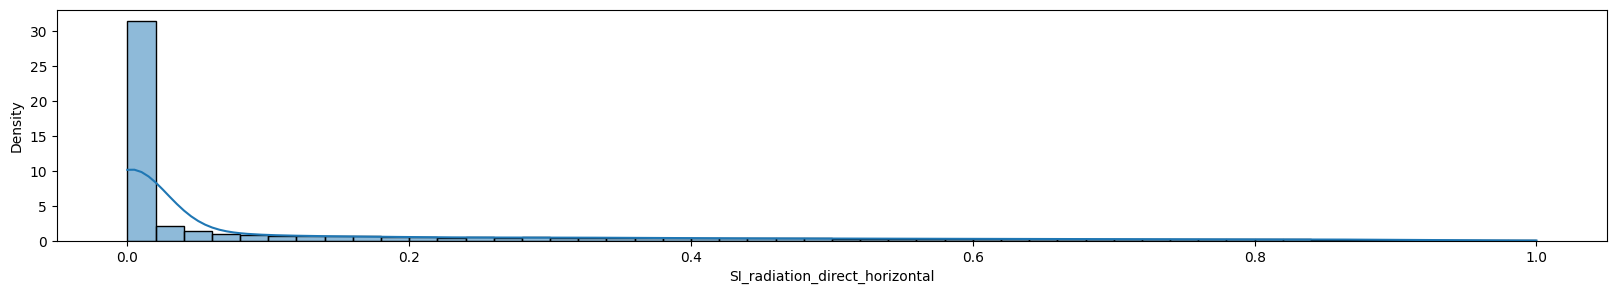

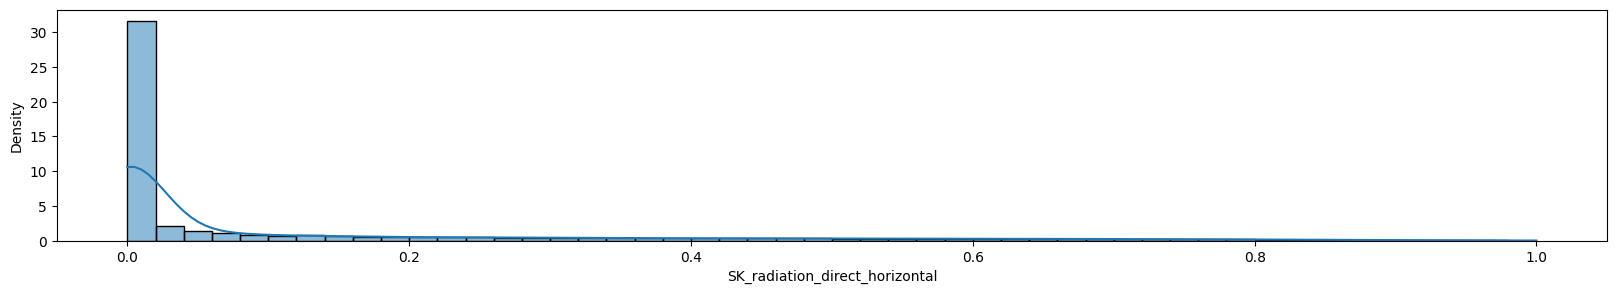

In [32]:
#Plotting solar radiation for each country


t_label = []
for feature_name in data.columns:
    if 'month' in feature_name or 'solar' in feature_name or 'temperature' in feature_name:
        continue;
    sns.histplot(data=data[feature_name], kde=True, label=feature_name, bins=50, stat='density', common_norm=False)
    plt.xlabel(feature_name)
    t_label.append(feature_name)
    plt.show()

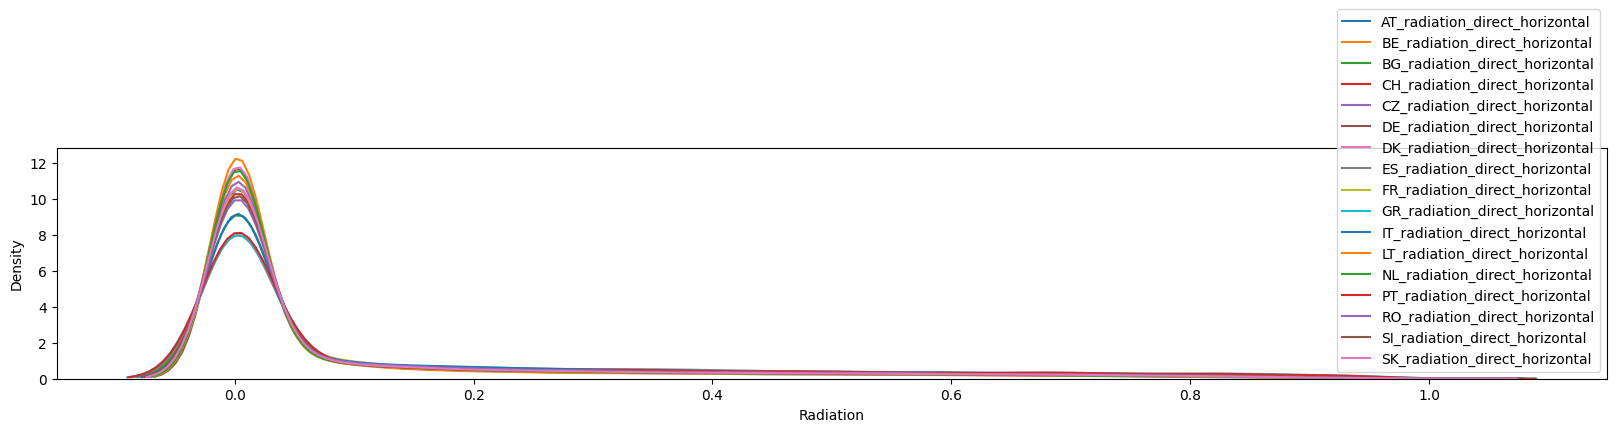

In [33]:
for feature_name in data.columns:
    if 'month' in feature_name or 'solar' in feature_name or 'temperature' in feature_name:
        continue;
    sns.kdeplot(data=data[feature_name], common_norm=False)
    plt.xlabel("Radiation")
    plt.legend(labels=t_label)

In [34]:
#Based on the previous distributions' analysis, countries with same (very similar) distributions 
#on both parameters (temperature, solar generation) will be deleted.
#Solar radiation distributions won't be considered, as they seem very similar for almost all of the countries.
dfs = [] #list of dataframes - one for each country
countries = ['BE', 'DK', 'FR', 'IT', 'LT', 'NL', 'PT', 'SK']

for country in countries:

    columns = [column for column in df.columns if (country in column or 'month' in column or 'month_sin' in column or 'month_cos' in column) ]
    dfs.append(df[columns])
print(dfs)

[                     BE_solar_generation_actual  BE_temperature  \
utc_timestamp                                                     
2015-01-01 00:00:00                         NaN          -0.046   
2015-01-01 01:00:00                         NaN          -0.302   
2015-01-01 02:00:00                         NaN          -0.541   
2015-01-01 03:00:00                         NaN          -0.794   
2015-01-01 04:00:00                         NaN          -1.053   
...                                         ...             ...   
2019-12-31 15:00:00                       13.14             NaN   
2019-12-31 16:00:00                        0.00             NaN   
2019-12-31 17:00:00                        0.00             NaN   
2019-12-31 18:00:00                        0.00             NaN   
2019-12-31 19:00:00                        0.00             NaN   

                     BE_radiation_direct_horizontal  
utc_timestamp                                        
2015-01-01 00:00:00

In [35]:
#Scalers used be saved as they will be utilized in the prediction process, where the inversed tranform method is used.
scalers = []
for df in dfs:
    scaler =  MinMaxScaler()
    df.iloc[:,0] = scaler.fit_transform(df.iloc[:,0].values.reshape(-1,1))
    scalers.append(scaler)
scalers

[MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler()]

In [36]:
#This function finds the missing values on a dataframe and splits the dataframe into groups, before and after each missing value.
#In this way, it achieves missing values removal. It returns the groups created after the missing values removal.

def split_missing_values(df: pd.DataFrame) -> [pd.DataFrame]:
    if not df.isna().any().any():
        # There are no missing values in any column
        return [df]

    groups = []
    last_line_was_valid = False
    idx_start = None
    idx_last_valid = None
    for idx, row in df.iterrows():
        row_is_missing_values = row.isna().any()
        if idx_start is None:
            idx_start = idx
            last_line_was_valid = not row_is_missing_values
            idx_last_valid = idx if last_line_was_valid else None
            continue

        if row_is_missing_values:
            if last_line_was_valid:
                groups.append(df.loc[idx_start:idx_last_valid])
                last_line_was_valid = False
            else:
                pass
        else:
            idx_last_valid = idx
            if last_line_was_valid:
                pass
            else:
                idx_start = idx
                last_line_was_valid = True

    # Remainder
    if last_line_was_valid:
        # Idx cannot be unassigned because last_line_was_valid is initialized with False
        groups.append(df.loc[idx_start:])

    return groups

In [37]:
#Here we remove the nans from each country with the use of the split_missing_values function and we save all of the returned 
#groups in a list. A list of lists is created, with each list represents a country.

nonans = []
for _df in dfs:
    nonans.append(split_missing_values(_df))
print(nonans)

[[                     BE_solar_generation_actual  BE_temperature  \
utc_timestamp                                                     
2015-01-01 08:00:00                    0.034217          -1.013   
2015-01-01 09:00:00                    0.138437           0.187   
2015-01-01 10:00:00                    0.273233           1.325   
2015-01-01 11:00:00                    0.346401           2.303   
2015-01-01 12:00:00                    0.313384           2.879   
...                                         ...             ...   
2019-12-30 19:00:00                    0.000000           0.381   
2019-12-30 20:00:00                    0.000000           0.142   
2019-12-30 21:00:00                    0.000000          -0.082   
2019-12-30 22:00:00                    0.000000          -0.175   
2019-12-30 23:00:00                    0.000000          -0.177   

                     BE_radiation_direct_horizontal  
utc_timestamp                                        
2015-01-01 08:00:0

In [38]:
#Windowing method which converts data into a form which can be utilized from a neural network
#It splits a multivariate sequence into samples, given a certain horizon and time steps
def split_sequences(sequences, n_steps, horizon=24):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + horizon > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix: end_ix + horizon, 0 ]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
#Returns the X,y test, train and validation tests which will be used from the models. These sets consists of data from all
#countries selected
def get_data():
    X_test_countries = []
    y_test_countries = []


    X_train_list = []
    X_test_list = []
    X_val_list = []
    y_train_list = []
    y_test_list = []
    y_val_list = []

    for i, df_country in enumerate (nonans):
        
        print(f'Country {i}')
        X_test_country = []
        y_test_country = []
    
        for group in df_country:
        
            in_seq1 = array(group.filter(regex=".*solar.*"))
            in_seq2 = array(group.filter(regex=".*temp.*"))
            in_seq3 = array(group.filter(regex=".*radiation.*"))
            in_seq4 = array(group.filter(regex=".*month_sin.*"))
            in_seq5 = array(group.filter(regex=".*month_cos.*"))


# convert to [rows, columns] structure
            in_seq1 = in_seq1.reshape((len(in_seq1), 1))
            in_seq2 = in_seq2.reshape((len(in_seq2), 1))
            in_seq3 = in_seq3.reshape((len(in_seq3), 1))
            in_seq4 = in_seq4.reshape((len(in_seq4), 1))
            in_seq5 = in_seq5.reshape((len(in_seq5), 1))


# horizontally stack columns
            data = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5))
        # choose a number of time steps and horizon
            n_steps = 24
            horizon = 24
# convert into input/output
            if len(data)<n_steps + horizon+1:
                continue;
            X, y = split_sequences(data, n_steps, horizon)
# the dataset knows the number of features, e.g. 2
            n_features = X.shape[2]

#split X, y
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
        
            X_test_country.extend(X_test)
            y_test_country.extend(y_test)
        
            X_train_list.extend(X_train)
            X_test_list.extend(X_test)
            X_val_list.extend(X_val)
            y_train_list.extend(y_train)
            y_test_list.extend(y_test)
            y_val_list.extend(y_val)
            
        print(f'Test size: {len(X_test_country)}')
        X_test_countries.append(X_test_country)
        y_test_countries.append(y_test_country)
        
    return X_train_list, y_train_list, X_test_countries, y_test_countries, X_val_list, y_val_list